# MF-DMA (Multifractal Detrended Moving Average) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15,

Wang, Yudong, et al. “Multifractal Detrending Moving Average Analysis on The US Dollar Exchange Rates.” Physica A, no. 390, 2011, pp. 3512–3523.

In [378]:
import datetime as dt
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_May2022_Nov2022.csv'
df0 = pd.read_csv(files)
df0

,Time,Price
0,5/1/2022 18:00,4140.436
1,5/1/2022 18:01,4146.245
2,5/1/2022 18:02,4147.945
3,5/1/2022 18:03,4151.999
4,5/1/2022 18:04,4151.351
...,...,...
230399,12/30/2022 16:08,3840.822
230400,12/30/2022 16:09,3841.06
230401,12/30/2022 16:10,3841.575
230402,12/30/2022 16:11,3842.816


Split dadasets by daylight savings time (Nov. 6, 2022)

In [4]:
# Locate the beginning data of non Daylight Savings time
df0[df0['Time']=='11/6/2022 18:00'].index

Index([178931], dtype='int64')

In [5]:
# Locate the data equivalent to 3:15 pm Chicago time on Nov 30, 2022
df0[df0['Time']=='11/30/2022 21:15'].index

Index([202683], dtype='int64')

In [6]:
# Select data in Daylight Savings time
df1 = df0[:178931]

# Set timestamp as index
df1 = df1.set_index(df1['Time'])
df1.drop(['Time'], axis=1, inplace=True)
df1.index = pd.to_datetime(df1.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df1.index = df1.index + pd.DateOffset(hours=3, minutes=45)
df1

,Price
Time,
2022-05-01 21:45:00,4140.436
2022-05-01 21:46:00,4146.245
2022-05-01 21:47:00,4147.945
2022-05-01 21:48:00,4151.999
2022-05-01 21:49:00,4151.351
...,...
2022-11-04 18:55:00,3770.569
2022-11-04 18:56:00,3770.572
2022-11-04 18:57:00,3770.316


In [7]:
# Similar preprossing the Daylight Savings time
df2 = df0[178931 : 202683]

df2 = df2.set_index(df2['Time'])
df2.drop(['Time'], axis=1, inplace=True)
df2.index = pd.to_datetime(df2.index)

df2.index = df2.index + pd.DateOffset(hours=2, minutes=45)
df2

,Price
Time,
2022-11-06 20:45:00,3740.48
2022-11-06 20:46:00,3744.239
2022-11-06 20:47:00,3741.613
2022-11-06 20:48:00,3743.619
2022-11-06 20:49:00,3744.48
...,...
2022-11-30 23:55:00,4079.189
2022-11-30 23:56:00,4078.198
2022-11-30 23:57:00,4077.686


In [8]:
df = pd.DataFrame(pd.concat([df1, df2]))
df

,Price
Time,
2022-05-01 21:45:00,4140.436
2022-05-01 21:46:00,4146.245
2022-05-01 21:47:00,4147.945
2022-05-01 21:48:00,4151.999
2022-05-01 21:49:00,4151.351
...,...
2022-11-30 23:55:00,4079.189
2022-11-30 23:56:00,4078.198
2022-11-30 23:57:00,4077.686


In [9]:
# Calculate log return
df['log_ret'] = np.log(df['Price'].astype(float)).diff() * 10000 # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )
df['missingT'] = df['deltaT'] - 1

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_16704\3242030435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,missingT,log_ret_sq
Time,,,,,
2022-05-01 21:46:00,4146.245,14.020091,1.0,0.0,196.562943
2022-05-01 21:47:00,4147.945,4.099255,1.0,0.0,16.803892
2022-05-01 21:48:00,4151.999,9.768741,1.0,0.0,95.428308
2022-05-01 21:49:00,4151.351,-1.560816,1.0,0.0,2.436146
2022-05-01 21:50:00,4150.936,-0.999725,1.0,0.0,0.999449
...,...,...,...,...,...
2022-11-30 23:55:00,4079.189,-0.590786,1.0,0.0,0.349028
2022-11-30 23:56:00,4078.198,-2.429700,1.0,0.0,5.903440
2022-11-30 23:57:00,4077.686,-1.255535,1.0,0.0,1.576369


In [10]:
# Count total days
f_date = dt.date(2022, 5, 1)
l_date = dt.date(2022, 12, 1)
len_calendar_days = (l_date - f_date).days
len_calendar_days

214

In [11]:
# Count the index trading days
cboe = mcal.get_calendar('CBOE_Index_Options')
trading_days = cboe.schedule(start_date='2022-05-01', end_date='2022-11-30')
len_trading_days = len(trading_days)
len_trading_days

153

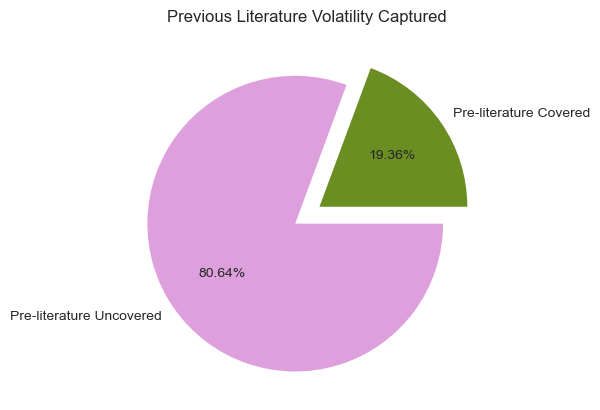

In [15]:
# Other researchers' data usage ratio
covered_pre_literature = (len_trading_days * 60 * 6.5) / (len_calendar_days * 60 * 24)
uncovered_pre_literature = 1 - covered_pre_literature

# Visualize
labels = 'Pre-literature Covered', 'Pre-literature Uncovered'
sizes = [covered_pre_literature, uncovered_pre_literature]
explode = (0.1, 0.1)
colors=['olivedrab', 'plum']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Previous Literature Volatility Captured')
plt.savefig('Previous Literature Volatility Captured.png')
plt.show()

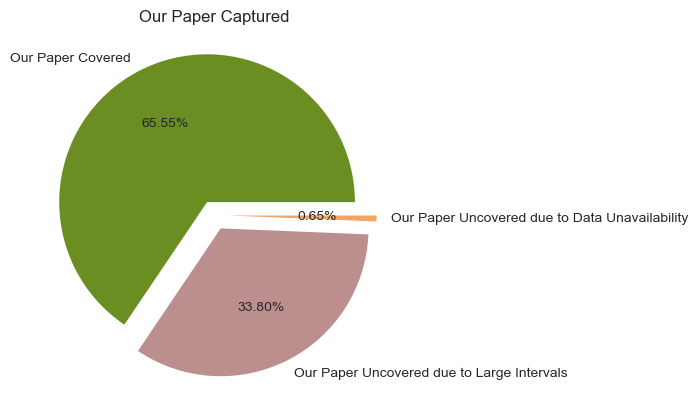

In [14]:
# Other researchers' data usage ratio
covered_our_paper = len(df_1min) / (len_calendar_days * 60 * 24)
uncovered_our_paper_large_interval = df['missingT'].sum() / (len_calendar_days * 60 * 24)
uncovered_data_unavailable = 1 - covered_our_paper - uncovered_our_paper_large_interval

# Visualize
labels = 'Our Paper Covered', 'Our Paper Uncovered due to Large Intervals', 'Our Paper Uncovered due to Data Unavailability'
sizes = [covered_our_paper, uncovered_our_paper_large_interval, uncovered_data_unavailable]
explode = (0.1, 0.1, 0.1)
colors=['olivedrab', 'rosybrown', 'sandybrown']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Our Paper Captured')
plt.savefig('Our Paper Captured.png')
plt.show()

In [16]:
df_1min['deltaT'].resample('1d').sum()

Time
2022-05-01     134.0
2022-05-02    1330.0
2022-05-03    1321.0
2022-05-04    1326.0
2022-05-05    1317.0
               ...  
2022-11-26       0.0
2022-11-27     190.0
2022-11-28    1323.0
2022-11-29    1328.0
2022-11-30    1330.0
Freq: D, Name: deltaT, Length: 214, dtype: float64

In [17]:
# Change the setting to show 1000 rows
pd.set_option('display.max_rows', 1000)

## Slice dataset into daily, weekly and monthly segments

### Determine how many data points in a day on average

In [18]:
available_daily = df_1min['deltaT'].resample('1d').count().to_frame()
available_daily['day_of_week'] = available_daily.index.dayofweek
print(available_daily)

            deltaT  day_of_week
Time                           
2022-05-01     134            6
2022-05-02    1330            0
2022-05-03    1321            1
2022-05-04    1326            2
2022-05-05    1317            3
2022-05-06    1200            4
2022-05-07       0            5
2022-05-08     134            6
2022-05-09    1332            0
2022-05-10    1325            1
2022-05-11    1332            2
2022-05-12    1334            3
2022-05-13    1200            4
2022-05-14       0            5
2022-05-15     134            6
2022-05-16    1330            0
2022-05-17    1332            1
2022-05-18    1332            2
2022-05-19    1334            3
2022-05-20    1200            4
2022-05-21       0            5
2022-05-22     134            6
2022-05-23    1334            0
2022-05-24    1328            1
2022-05-25    1332            2
2022-05-26    1334            3
2022-05-27    1200            4
2022-05-28       0            5
2022-05-29     134            6
2022-05-

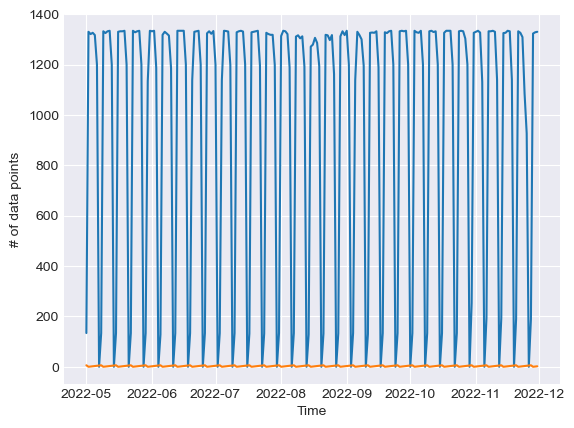

In [24]:
plt.plot(available_daily)
plt.xlabel('Time')
plt.ylabel('# of data points')
plt.savefig('Available Daily.png')
plt.show()

In [20]:
# Average daily data availability
avg_daily = int(available_daily['deltaT'].sum() / len_trading_days)
avg_daily

1320

### Determine how many data points in a week on average

In [21]:
available_weekly =  df_1min['deltaT'].resample('1w').count().to_frame()

print(available_weekly)

            deltaT
Time              
2022-05-01     134
2022-05-08    6628
2022-05-15    6657
2022-05-22    6662
2022-05-29    6662
2022-06-05    6449
2022-06-12    6606
2022-06-19    6670
2022-06-26    6468
2022-07-03    6645
2022-07-10    6468
2022-07-17    6657
2022-07-24    6652
2022-07-31    6615
2022-08-07    6622
2022-08-14    6563
2022-08-21    6468
2022-08-28    6543
2022-09-04    6627
2022-09-11    6411
2022-09-18    6634
2022-09-25    6653
2022-10-02    6666
2022-10-09    6656
2022-10-16    6661
2022-10-23    6662
2022-10-30    6754
2022-11-06    6642
2022-11-13    6662
2022-11-20    6648
2022-11-27    6169
2022-12-04    3981


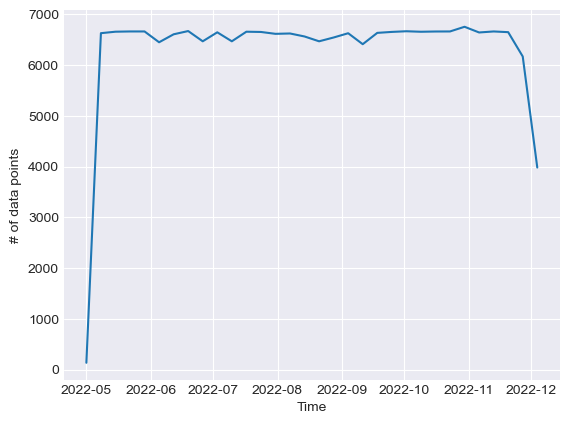

In [25]:
plt.plot(available_weekly)
plt.xlabel('Time')
plt.ylabel('# of data points')
plt.savefig('Available Weekly.png')
plt.show()

#### Method one: drop incomplete week data points

In [26]:
# Drop the incomplete first and last week

available_weekly_drop = available_weekly.loc[available_weekly['deltaT']!=available_weekly['deltaT'].min()]
available_weekly_drop = available_weekly.loc[available_weekly['deltaT']!=available_weekly['deltaT'].min()]

available_weekly_drop

,deltaT
Time,
2022-05-08,6628
2022-05-15,6657
2022-05-22,6662
2022-05-29,6662
2022-06-05,6449
2022-06-12,6606
2022-06-19,6670
2022-06-26,6468
2022-07-03,6645


In [27]:
avg_weekly1 = int(available_weekly_drop.mean())
avg_weekly1

C:\Users\cutef\AppData\Local\Temp\ipykernel_16704\2082506604.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_weekly1 = int(available_weekly_drop.mean())


6511

#### Method Two: don't drop incomplete weekly data points

In [28]:
avg_weekly = int(available_weekly.mean())
avg_weekly

C:\Users\cutef\AppData\Local\Temp\ipykernel_16704\2549662872.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_weekly = int(available_weekly.mean())


6312

### Determine how many data points in a month on average

In [29]:
available_monthly =  df_1min['deltaT'].resample('1m').count().to_frame()
available_monthly

,deltaT
Time,
2022-05-31,29211
2022-06-30,29036
2022-07-31,27726
2022-08-31,30157
2022-09-30,28896
2022-10-31,28193
2022-11-30,28776


In [30]:
avg_monthly = available_monthly['deltaT'][:-2].mean() # Discard December 2022 because of data incompleteness
avg_monthly

29005.2

### Determine conversion ratio between daily, weekly and monthly

In [31]:
ratio_weekly = int(round(avg_weekly / avg_daily, 0))
ratio_monthly = int(round(avg_monthly / avg_daily, 0))

print(f'Conversion ratio of weekly and monthly to daily are {ratio_weekly} and {ratio_monthly}, respectively')

Conversion ratio of weekly and monthly to daily are 5 and 22, respectively


In [32]:
modified_weekly_data = int(ratio_weekly * avg_daily)
modified_monthly_data = int(ratio_monthly * avg_daily)

print(f'We use {avg_daily}, {modified_weekly_data} \
and {modified_monthly_data} data points, respectively for daily, weekly and monthly available dataset')

We use 1320, 6600 and 29040 data points, respectively for daily, weekly and monthly available dataset


In [33]:
# Change the setting to show 200 rows
pd.set_option('display.max_rows', 200)

#### Prepare the dataframe of the modified dataset

In [34]:
modified_data = df_1min['log_ret_sq'].copy()

number_modified_data = len(modified_data) // avg_daily * avg_daily
modified_data = modified_data[-number_modified_data:]
print(modified_data)
modified_data.to_csv('Modified Data_08192023.csv')

Time
2022-05-01 22:21:00    53.134022
2022-05-01 22:22:00    17.946388
2022-05-01 22:23:00    27.482164
2022-05-01 22:24:00     4.727767
2022-05-01 22:25:00     2.902775
                         ...    
2022-11-30 23:55:00     0.349028
2022-11-30 23:56:00     5.903440
2022-11-30 23:57:00     1.576369
2022-11-30 23:58:00     0.000866
2022-11-30 23:59:00     1.540015
Name: log_ret_sq, Length: 201960, dtype: float64


#### Determine how many observations in our final analysis

In [35]:
num_obs = int(len(modified_data) // avg_daily - ratio_monthly + 1)
num_obs

132

#### Resize the modified data into observation-numbered series

In [36]:
monthly_resized_data = pd.DataFrame(index=np.arange(modified_monthly_data), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs + ratio_monthly - 1) * avg_daily)

    for i in range(modified_monthly_data):
        monthly_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} monthly columns prepared,', 
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All monthly columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 132 monthly columns prepared, total time spent till now is 0 min(s) 33 sec(s).
20 out of 132 monthly columns prepared, total time spent till now is 1 min(s) 8 sec(s).
30 out of 132 monthly columns prepared, total time spent till now is 1 min(s) 44 sec(s).
40 out of 132 monthly columns prepared, total time spent till now is 2 min(s) 20 sec(s).
50 out of 132 monthly columns prepared, total time spent till now is 2 min(s) 55 sec(s).
60 out of 132 monthly columns prepared, total time spent till now is 3 min(s) 31 sec(s).
70 out of 132 monthly columns prepared, total time spent till now is 4 min(s) 7 sec(s).
80 out of 132 monthly columns prepared, total time spent till now is 4 min(s) 42 sec(s).
90 out of 132 monthly columns prepared, total time spent till now is 5 min(s) 18 sec(s).
100 out of 132 monthly columns prepared, total time spent till now is 5 min(s) 55 sec(s).
110 out of 132 monthly columns prepared, total time spent till now is 6 min(s) 32 sec(s).
120 out of 132 monthl

In [37]:
monthly_resized_data.to_csv('Monthly Resized Data_08192023.csv')
monthly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,53.134022,0.0,0.041339,0.357585,0.226119,34.117894,63.591427,3.041037,27.456605,176.736594,...,2.253021,2.282419,7.272864,5.0516,0.283311,4.96466,208.589627,61.172404,0.000236,1.662129
1,17.946388,1.800878,0.083767,1.076743,0.042099,0.000054,1.581546,56.502672,58.800574,2.431734,...,35.385649,0.720684,0.015183,17.875842,19.588923,23.720714,70.734734,0.845238,0.420449,120.205072
2,27.482164,0.013372,0.680915,1.288807,5.617754,9.466212,1.544043,0.000508,3.277272,9.296188,...,0.463591,1.883365,2.194817,0.123307,0.000999,28.72308,34.128553,147.415473,58.753594,6.465528
3,4.727767,8.189065,10.583717,3.593617,2.854344,93.422903,34.702114,316.053819,14.729104,71.806141,...,21.280552,0.996123,7.502172,0.128933,1.611521,39.924081,232.530637,0.921864,0.000321,25.489115
4,2.902775,28.013484,0.228972,1.288026,6.036322,13.325506,16.661257,7.393982,14.553966,838.471219,...,3.9082,2.994864,0.679834,0.000063,3.706851,0.21398,15.428628,7.043965,1.580841,0.604571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,2.241239,10.082834,9.624877,13.415521,17.029367,2.416534,0.256904,6.048612,196.309897,35.465608,...,41.35399,9.960591,3.383298,6.311703,3.454972,0.533525,1.618992,0.001427,3.676861,0.349028
29036,0.60463,10.222579,1.460466,0.215856,35.075375,0.500408,0.0,1.227193,131.494343,63.670289,...,6.976556,1.793564,0.838917,14.010888,3.595322,0.533525,0.001406,0.001427,0.873521,5.90344
29037,23.815068,3.347761,27.768177,94.61653,13.305826,37.915036,6.060321,125.899344,93.1005,25.381176,...,0.402496,31.692028,0.867036,1.627806,1.665921,0.108458,0.000225,0.396388,0.096528,1.576369
29038,23.509377,183.445758,1.423988,23.511173,93.661095,6.461368,0.22146,14.065315,20.925966,31.514325,...,0.412267,10.010953,9.991813,3.490474,9.348903,0.10684,0.353903,0.377543,0.398757,0.000866


In [38]:
weekly_resized_data = pd.DataFrame(index=np.arange(modified_weekly_data), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs + ratio_weekly - 1) * avg_daily)
    
    for i in range(modified_weekly_data):
        weekly_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} weekly columns prepared,',
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All weekly columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 5 sec(s).
20 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 11 sec(s).
30 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 16 sec(s).
40 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 21 sec(s).
50 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 27 sec(s).
60 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 32 sec(s).
70 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 38 sec(s).
80 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 43 sec(s).
90 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 48 sec(s).
100 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 54 sec(s).
110 out of 132 weekly columns prepared, total time spent till now is 0 min(s) 59 sec(s).
120 out of 132 weekly columns p

In [39]:
weekly_resized_data.to_csv('Weekly Resized Data_08192023.csv')
weekly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,0.000234,5.657267,8.077214,13.188582,18.560419,30.812107,0.545522,70.187176,13.574102,2.771306,...,0.398623,1.531688,1.219088,1.465057,0.000913,128.646432,0.000232,19.973578,3.33359,1.508792
1,0.000527,15.571322,6.768369,1.466108,9.169675,7.013347,23.777507,70.670743,64.584212,1.547807,...,19.210293,0.403307,0.014379,9.805189,4.788815,1.567137,26.759483,6.626647,6.023077,3.575063
2,217.968857,0.368384,2.994212,23.61301,5.745285,0.269913,23.515892,1.47602,5.924392,93.661095,...,25.970473,13.517091,0.591993,223.122828,4.933149,6.215565,7.141509,13.757179,0.391347,9.682289
3,10.980335,32.1066,1.551143,13.310429,1.712127,5.805832,13.282573,101.602597,31.513778,19.273863,...,0.330151,4.028479,13.09669,24.318965,9.988847,1.208953,47.890524,1.483649,0.391347,5.405708
4,3.061236,32.546174,3.877032,9.871884,9.66293,0.504943,5.843527,4.786887,21.531285,0.362102,...,0.018318,8.760108,9.553767,37.793488,10.100569,3.98673,19.160134,3.42197,6.14699,0.224221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,2.241239,10.082834,9.624877,13.415521,17.029367,2.416534,0.256904,6.048612,196.309897,35.465608,...,41.35399,9.960591,3.383298,6.311703,3.454972,0.533525,1.618992,0.001427,3.676861,0.349028
6596,0.60463,10.222579,1.460466,0.215856,35.075375,0.500408,0.0,1.227193,131.494343,63.670289,...,6.976556,1.793564,0.838917,14.010888,3.595322,0.533525,0.001406,0.001427,0.873521,5.90344
6597,23.815068,3.347761,27.768177,94.61653,13.305826,37.915036,6.060321,125.899344,93.1005,25.381176,...,0.402496,31.692028,0.867036,1.627806,1.665921,0.108458,0.000225,0.396388,0.096528,1.576369
6598,23.509377,183.445758,1.423988,23.511173,93.661095,6.461368,0.22146,14.065315,20.925966,31.514325,...,0.412267,10.010953,9.991813,3.490474,9.348903,0.10684,0.353903,0.377543,0.398757,0.000866


In [40]:
daily_resized_data = pd.DataFrame(index=np.arange(avg_daily), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs) * avg_daily)

    for i in range(avg_daily):
        daily_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} daily columns prepared,',
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All daily columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 132 daily columns prepared, total time spent till now is 0 min(s) 0 sec(s).
20 out of 132 daily columns prepared, total time spent till now is 0 min(s) 1 sec(s).
30 out of 132 daily columns prepared, total time spent till now is 0 min(s) 2 sec(s).
40 out of 132 daily columns prepared, total time spent till now is 0 min(s) 3 sec(s).
50 out of 132 daily columns prepared, total time spent till now is 0 min(s) 4 sec(s).
60 out of 132 daily columns prepared, total time spent till now is 0 min(s) 5 sec(s).
70 out of 132 daily columns prepared, total time spent till now is 0 min(s) 6 sec(s).
80 out of 132 daily columns prepared, total time spent till now is 0 min(s) 7 sec(s).
90 out of 132 daily columns prepared, total time spent till now is 0 min(s) 8 sec(s).
100 out of 132 daily columns prepared, total time spent till now is 0 min(s) 9 sec(s).
110 out of 132 daily columns prepared, total time spent till now is 0 min(s) 10 sec(s).
120 out of 132 daily columns prepared, total time s

In [41]:
daily_resized_data.to_csv('Daily Resized Data_08192023.csv')
daily_resized_data

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,18.560419,30.812107,0.545522,70.187176,13.574102,2.771306,0.41506,2.931841,17.658581,89.41744,...,0.000913,128.646432,0.000232,19.973578,3.33359,1.508792,0.024334,0.001406,3.567043,0.61312
1,9.169675,7.013347,23.777507,70.670743,64.584212,1.547807,3.207775,22.488272,0.119714,0.00094,...,4.788815,1.567137,26.759483,6.626647,6.023077,3.575063,1.551445,3.347733,0.000057,0.000919
2,5.745285,0.269913,23.515892,1.47602,5.924392,93.661095,5.851539,115.765744,26.009108,6.411881,...,4.933149,6.215565,7.141509,13.757179,0.391347,9.682289,0.392526,0.000056,0.120793,0.389291
3,1.712127,5.805832,13.282573,101.602597,31.513778,19.273863,5.750077,1.468322,3.88464,21.027718,...,9.988847,1.208953,47.890524,1.483649,0.391347,5.405708,0.430589,0.000056,0.075364,0.555289
4,9.66293,0.504943,5.843527,4.786887,21.531285,0.362102,13.860144,2.853433,3.97286,20.957466,...,10.100569,3.98673,19.160134,3.42197,6.14699,0.224221,0.374127,0.000056,0.359294,0.58969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2.241239,10.082834,9.624877,13.415521,17.029367,2.416534,0.256904,6.048612,196.309897,35.465608,...,41.35399,9.960591,3.383298,6.311703,3.454972,0.533525,1.618992,0.001427,3.676861,0.349028
1316,0.60463,10.222579,1.460466,0.215856,35.075375,0.500408,0.0,1.227193,131.494343,63.670289,...,6.976556,1.793564,0.838917,14.010888,3.595322,0.533525,0.001406,0.001427,0.873521,5.90344
1317,23.815068,3.347761,27.768177,94.61653,13.305826,37.915036,6.060321,125.899344,93.1005,25.381176,...,0.402496,31.692028,0.867036,1.627806,1.665921,0.108458,0.000225,0.396388,0.096528,1.576369
1318,23.509377,183.445758,1.423988,23.511173,93.661095,6.461368,0.22146,14.065315,20.925966,31.514325,...,0.412267,10.010953,9.991813,3.490474,9.348903,0.10684,0.353903,0.377543,0.398757,0.000866


In [42]:
# Prepare the final dataframe to analyze
final_data_cols = ['H_Daily', 'H_Weekly', 'H_Monthly', 'Real_VIX']
final_data = pd.DataFrame(index=np.arange(num_obs), columns=final_data_cols)
final_data.to_csv('Final Data_Empty_08192023.csv')
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


# Analyze daily cleaned data

In [51]:
daily_resized_data = pd.read_csv('Daily Resized Data_08192023.csv', index_col=0)
daily_resized_data

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,18.560419,30.812107,0.545522,70.187176,13.574102,2.771306,0.415060,2.931841,17.658581,89.417440,...,0.000913,128.646432,0.000232,19.973578,3.333590,1.508792,0.024334,0.001406,3.567043,0.613120
1,9.169675,7.013347,23.777507,70.670743,64.584212,1.547807,3.207775,22.488272,0.119714,0.000940,...,4.788815,1.567137,26.759483,6.626647,6.023077,3.575063,1.551445,3.347733,0.000057,0.000919
2,5.745285,0.269913,23.515892,1.476020,5.924392,93.661095,5.851539,115.765744,26.009108,6.411881,...,4.933149,6.215565,7.141509,13.757179,0.391347,9.682289,0.392526,0.000056,0.120793,0.389291
3,1.712127,5.805832,13.282573,101.602597,31.513778,19.273863,5.750077,1.468322,3.884640,21.027718,...,9.988847,1.208953,47.890524,1.483649,0.391347,5.405708,0.430589,0.000056,0.075364,0.555289
4,9.662930,0.504943,5.843527,4.786887,21.531285,0.362102,13.860144,2.853433,3.972860,20.957466,...,10.100569,3.986730,19.160134,3.421970,6.146990,0.224221,0.374127,0.000056,0.359294,0.589690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2.241239,10.082834,9.624877,13.415521,17.029367,2.416534,0.256904,6.048612,196.309897,35.465608,...,41.353990,9.960591,3.383298,6.311703,3.454972,0.533525,1.618992,0.001427,3.676861,0.349028
1316,0.604630,10.222579,1.460466,0.215856,35.075375,0.500408,0.000000,1.227193,131.494343,63.670289,...,6.976556,1.793564,0.838917,14.010888,3.595322,0.533525,0.001406,0.001427,0.873521,5.903440
1317,23.815068,3.347761,27.768177,94.616530,13.305826,37.915036,6.060321,125.899344,93.100500,25.381176,...,0.402496,31.692028,0.867036,1.627806,1.665921,0.108458,0.000225,0.396388,0.096528,1.576369
1318,23.509377,183.445758,1.423988,23.511173,93.661095,6.461368,0.221460,14.065315,20.925966,31.514325,...,0.412267,10.010953,9.991813,3.490474,9.348903,0.106840,0.353903,0.377543,0.398757,0.000866


In [52]:
# Define parameters
n_sample = avg_daily
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

daily_cumsum = daily_resized_data.cumsum(axis=0)
daily_cumsum.to_csv('Daily Cumsum_08192023.csv')
daily_cumsum

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,18.560419,30.812107,0.545522,70.187176,13.574102,2.771306,0.415060,2.931841,17.658581,89.417440,...,0.000913,128.646432,0.000232,19.973578,3.333590,1.508792,0.024334,0.001406,3.567043,0.613120
1,27.730094,37.825454,24.323029,140.857919,78.158314,4.319113,3.622835,25.420113,17.778296,89.418380,...,4.789728,130.213569,26.759715,26.600225,9.356667,5.083855,1.575779,3.349139,3.567100,0.614039
2,33.475379,38.095367,47.838921,142.333939,84.082706,97.980208,9.474374,141.185857,43.787404,95.830261,...,9.722878,136.429134,33.901224,40.357404,9.748014,14.766144,1.968305,3.349195,3.687893,1.003330
3,35.187506,43.901199,61.121494,243.936536,115.596484,117.254072,15.224452,142.654179,47.672043,116.857979,...,19.711725,137.638087,81.791748,41.841052,10.139361,20.171852,2.398894,3.349252,3.763257,1.558620
4,44.850436,44.406142,66.965021,248.723423,137.127768,117.616173,29.084595,145.507612,51.644903,137.815445,...,29.812294,141.624816,100.951882,45.263023,16.286351,20.396074,2.773022,3.349308,4.122551,2.148309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,24713.726765,19735.912071,17624.836977,19217.111237,13705.638606,14330.242182,11432.989074,18012.750381,41329.099050,38015.140367,...,12120.680438,11522.146536,8940.276910,6624.406774,5098.187735,5204.686740,2668.871877,6646.758614,7885.551177,15871.368865
1316,24714.331396,19746.134650,17626.297443,19217.327093,13740.713981,14330.742590,11432.989074,18013.977574,41460.593393,38078.810655,...,12127.656994,11523.940100,8941.115826,6638.417662,5101.783057,5205.220265,2668.873283,6646.760041,7886.424698,15877.272305
1317,24738.146464,19749.482411,17654.065620,19311.943623,13754.019807,14368.657626,11439.049395,18139.876918,41553.693893,38104.191831,...,12128.059491,11555.632128,8941.982862,6640.045468,5103.448978,5205.328723,2668.873508,6647.156429,7886.521226,15878.848674
1318,24761.655841,19932.928169,17655.489607,19335.454796,13847.680902,14375.118995,11439.270854,18153.942233,41574.619859,38135.706157,...,12128.471758,11565.643081,8951.974675,6643.535942,5112.797881,5205.435563,2669.227410,6647.533972,7886.919984,15878.849540


## In the for-loop:
### 1. Construct the sequence of cumulative sums
### 2. Calculate moving average
### 3. Detrend
### 4. Define non-overlapping segments and calculate each fluctuation variance
### 5. Calculate q-th order fluctuation function

In [53]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_daily = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_daily.to_csv('Daily F Summary_Empty_08192023.csv')
F_summary_daily

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130,q_2.0_131
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = daily_cumsum[str(col)]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_daily.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_daily[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Daily'][col] = hurst_hat
    
    if (col+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 132 columns are done, total time spent till now is 0 min(s) 56 sec(s).
20 out of 132 columns are done, total time spent till now is 1 min(s) 53 sec(s).
30 out of 132 columns are done, total time spent till now is 2 min(s) 49 sec(s).
40 out of 132 columns are done, total time spent till now is 3 min(s) 46 sec(s).
50 out of 132 columns are done, total time spent till now is 4 min(s) 43 sec(s).
60 out of 132 columns are done, total time spent till now is 5 min(s) 39 sec(s).
70 out of 132 columns are done, total time spent till now is 6 min(s) 35 sec(s).
80 out of 132 columns are done, total time spent till now is 7 min(s) 32 sec(s).
90 out of 132 columns are done, total time spent till now is 8 min(s) 28 sec(s).
100 out of 132 columns are done, total time spent till now is 9 min(s) 25 sec(s).
110 out of 132 columns are done, total time spent till now is 10 min(s) 22 sec(s).
120 out of 132 columns are done, total time spent till now is 11 min(s) 18 sec(s).
130 out of 132 columns 

In [59]:
F_summary_daily.to_csv('Daily F Summary_08192023.csv')
F_summary_daily

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130,q_2.0_131
s_3,11.303735,9.62386,11.215585,13.532693,7.813583,10.550197,6.486086,10.160159,106.226613,18.113926,...,9.024981,5.386639,4.868816,3.26252,3.660267,9.729254,1.46571,6.623688,4.31702,17.455757
s_4,12.057841,9.96367,12.643308,12.324791,8.875995,13.135845,6.4728,11.339463,80.432312,20.07414,...,8.089666,6.201643,4.745727,3.704645,3.263883,11.803416,1.411305,5.233911,4.601175,17.420778
s_5,12.568979,10.072235,14.016758,14.257279,8.756201,12.965715,7.770034,11.264939,120.688845,21.384764,...,7.983344,6.298082,4.753551,3.594232,4.638077,8.923285,1.484445,7.031895,4.770969,18.830128
s_6,12.117091,10.798183,14.614904,13.96979,8.902193,12.643068,6.98321,12.113706,101.916646,20.012424,...,9.926651,6.459587,5.832948,3.788172,4.831211,12.924394,1.685463,9.952103,4.709533,18.607215
s_7,13.525733,10.896146,13.302418,15.8764,8.646439,14.541295,7.557657,12.504383,131.77641,22.458144,...,8.486987,7.055698,5.731289,4.041408,4.421513,8.923573,1.763428,10.252127,4.789511,24.247196
s_8,12.982864,11.165714,12.04553,15.355966,9.646296,12.894214,7.397218,13.255162,124.72208,21.029848,...,8.654778,6.715501,6.430543,3.903005,3.660703,13.201687,1.827988,5.957565,5.032533,19.02049
s_9,13.844812,11.476382,15.086618,16.761515,9.188344,12.118901,7.201337,13.247583,131.698859,21.092975,...,10.047081,6.98066,6.845325,4.176612,4.706465,13.335232,1.867892,10.995092,4.884011,19.851639
s_10,13.366381,11.102555,15.38102,17.28812,9.272863,13.900201,7.745227,14.122766,118.475907,19.890702,...,10.581738,6.792236,7.604814,4.140919,5.197151,14.79601,1.892306,11.990308,5.413105,17.30788
s_11,14.292121,11.204005,13.732347,17.135393,10.140763,14.506785,8.410801,15.756266,115.192645,20.942001,...,8.358439,6.292721,6.477964,4.451227,4.383629,15.930434,1.795952,10.706413,5.212265,24.68338
s_12,14.121786,11.6363,14.820327,18.746318,9.699955,14.371207,8.358572,13.045483,140.615436,23.370603,...,10.675079,6.788128,8.368759,4.590134,4.671806,12.354482,2.047747,10.785219,5.363001,16.925541


In [60]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.253341,NaN,NaN,NaN
1,0.265794,NaN,NaN,NaN
2,0.368227,NaN,NaN,NaN
3,0.292981,NaN,NaN,NaN
4,0.283007,NaN,NaN,NaN
5,0.205196,NaN,NaN,NaN
6,0.203497,NaN,NaN,NaN
7,0.254768,NaN,NaN,NaN
8,0.098147,NaN,NaN,NaN
9,0.268702,NaN,NaN,NaN


In [61]:
# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_daily_08192023.csv')

# Analyze weekly cleaned data

In [62]:
weekly_resized_data = pd.read_csv('Weekly Resized Data_08192023.csv', index_col=0)
weekly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,0.000234,5.657267,8.077214,13.188582,18.560419,30.812107,0.545522,70.187176,13.574102,2.771306,...,0.398623,1.531688,1.219088,1.465057,0.000913,128.646432,0.000232,19.973578,3.333590,1.508792
1,0.000527,15.571322,6.768369,1.466108,9.169675,7.013347,23.777507,70.670743,64.584212,1.547807,...,19.210293,0.403307,0.014379,9.805189,4.788815,1.567137,26.759483,6.626647,6.023077,3.575063
2,217.968857,0.368384,2.994212,23.613010,5.745285,0.269913,23.515892,1.476020,5.924392,93.661095,...,25.970473,13.517091,0.591993,223.122828,4.933149,6.215565,7.141509,13.757179,0.391347,9.682289
3,10.980335,32.106600,1.551143,13.310429,1.712127,5.805832,13.282573,101.602597,31.513778,19.273863,...,0.330151,4.028479,13.096690,24.318965,9.988847,1.208953,47.890524,1.483649,0.391347,5.405708
4,3.061236,32.546174,3.877032,9.871884,9.662930,0.504943,5.843527,4.786887,21.531285,0.362102,...,0.018318,8.760108,9.553767,37.793488,10.100569,3.986730,19.160134,3.421970,6.146990,0.224221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,2.241239,10.082834,9.624877,13.415521,17.029367,2.416534,0.256904,6.048612,196.309897,35.465608,...,41.353990,9.960591,3.383298,6.311703,3.454972,0.533525,1.618992,0.001427,3.676861,0.349028
6596,0.604630,10.222579,1.460466,0.215856,35.075375,0.500408,0.000000,1.227193,131.494343,63.670289,...,6.976556,1.793564,0.838917,14.010888,3.595322,0.533525,0.001406,0.001427,0.873521,5.903440
6597,23.815068,3.347761,27.768177,94.616530,13.305826,37.915036,6.060321,125.899344,93.100500,25.381176,...,0.402496,31.692028,0.867036,1.627806,1.665921,0.108458,0.000225,0.396388,0.096528,1.576369
6598,23.509377,183.445758,1.423988,23.511173,93.661095,6.461368,0.221460,14.065315,20.925966,31.514325,...,0.412267,10.010953,9.991813,3.490474,9.348903,0.106840,0.353903,0.377543,0.398757,0.000866


In [63]:
# Define parameters
n_sample = modified_weekly_data
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

weekly_cumsum = weekly_resized_data.cumsum(axis=0)
weekly_cumsum.to_csv('Weekly Cumsum_08192023.csv')
weekly_cumsum

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,0.000234,5.657267,8.077214,13.188582,18.560419,30.812107,0.545522,70.187176,13.574102,2.771306,...,0.398623,1.531688,1.219088,1.465057,0.000913,128.646432,0.000232,19.973578,3.333590,1.508792
1,0.000762,21.228589,14.845583,14.654689,27.730094,37.825454,24.323029,140.857919,78.158314,4.319113,...,19.608916,1.934996,1.233467,11.270246,4.789728,130.213569,26.759715,26.600225,9.356667,5.083855
2,217.969619,21.596973,17.839795,38.267700,33.475379,38.095367,47.838921,142.333939,84.082706,97.980208,...,45.579389,15.452087,1.825460,234.393074,9.722878,136.429134,33.901224,40.357404,9.748014,14.766144
3,228.949953,53.703573,19.390938,51.578128,35.187506,43.901199,61.121494,243.936536,115.596484,117.254072,...,45.909540,19.480566,14.922150,258.712039,19.711725,137.638087,81.791748,41.841052,10.139361,20.171852
4,232.011190,86.249747,23.267970,61.450013,44.850436,44.406142,66.965021,248.723423,137.127768,117.616173,...,45.927858,28.240674,24.475917,296.505527,29.812294,141.624816,100.951882,45.263023,16.286351,20.396074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,86206.156085,82053.304815,79154.169203,87701.790754,95483.551342,85183.987910,76702.030525,77067.061683,99207.425563,123761.488559,...,82307.009107,77609.926254,74242.108049,63270.013901,44406.462035,37493.582294,28594.568179,26287.525316,27529.223701,38283.038331
6596,86206.760715,82063.527394,79155.629669,87702.006609,95518.626717,85184.488318,76702.030525,77068.288876,99338.919906,123825.158848,...,82313.985663,77611.719818,74242.946966,63284.024788,44410.057357,37494.115819,28594.569585,26287.526743,27530.097221,38288.941771
6597,86230.575784,82066.875155,79183.397846,87796.623140,95531.932544,85222.403354,76708.090846,77194.188220,99432.020406,123850.540023,...,82314.388159,77643.411846,74243.814002,63285.652594,44411.723278,37494.224277,28594.569810,26287.923131,27530.193749,38290.518140
6598,86254.085161,82250.320913,79184.821834,87820.134312,95625.593639,85228.864723,76708.312306,77208.253535,99452.946372,123882.054349,...,82314.800426,77653.422798,74253.805814,63289.143069,44421.072181,37494.331116,28594.923713,26288.300673,27530.592507,38290.519006


In [64]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_weekly = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_weekly.to_csv('Weekly F Summary_Empty_08192023.csv')
F_summary_weekly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130,q_2.0_131
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = weekly_cumsum[str(col)]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_weekly.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_weekly[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Weekly'][col] = hurst_hat
    
    if (col+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 132 columns are done, total time spent till now is 5 min(s) 23 sec(s).
20 out of 132 columns are done, total time spent till now is 10 min(s) 45 sec(s).
30 out of 132 columns are done, total time spent till now is 16 min(s) 7 sec(s).
40 out of 132 columns are done, total time spent till now is 21 min(s) 30 sec(s).
50 out of 132 columns are done, total time spent till now is 26 min(s) 50 sec(s).
60 out of 132 columns are done, total time spent till now is 32 min(s) 14 sec(s).
70 out of 132 columns are done, total time spent till now is 37 min(s) 35 sec(s).
80 out of 132 columns are done, total time spent till now is 43 min(s) 0 sec(s).
90 out of 132 columns are done, total time spent till now is 48 min(s) 21 sec(s).
100 out of 132 columns are done, total time spent till now is 53 min(s) 41 sec(s).
110 out of 132 columns are done, total time spent till now is 59 min(s) 7 sec(s).
120 out of 132 columns are done, total time spent till now is 64 min(s) 28 sec(s).
130 out of 132 co

In [66]:
F_summary_weekly.to_csv('Weekly F Summary_08192023.csv')
F_summary_weekly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130,q_2.0_131
s_3,10.658167,10.420513,8.694055,10.348303,10.860663,10.713151,10.231286,10.015905,48.129546,48.682159,...,16.887508,16.534358,16.466535,7.959216,5.636794,5.85071,5.372105,5.734584,5.872051,9.624731
s_4,12.124587,11.652032,9.374252,10.629456,11.264224,11.505837,10.994895,10.714983,37.083987,37.949893,...,17.000644,16.719582,16.547826,7.997869,5.506407,6.698112,6.128153,6.206784,6.325316,9.921344
s_5,12.323271,11.821693,9.928426,11.566757,12.12324,12.206983,11.861553,11.267942,54.688126,55.381773,...,18.935615,18.547213,18.391328,8.91273,5.677394,5.933192,5.26224,5.748193,5.916444,10.070465
s_6,11.854752,10.945616,10.174297,11.665626,12.251812,12.357479,11.78982,11.215516,46.441108,47.13277,...,17.363517,16.959743,16.863761,9.121751,6.519258,7.479715,6.939628,7.817435,7.91588,11.269562
s_7,12.781628,12.081406,10.435115,12.040865,11.735736,13.319374,10.296736,11.872349,59.539567,41.120043,...,15.277621,18.780806,18.673098,9.784145,6.505524,6.321797,6.773067,7.961895,6.375666,13.654362
s_8,12.32194,11.716383,9.79609,11.703667,12.382099,12.364692,11.773622,12.032399,56.514405,57.140319,...,16.905666,16.37659,16.319438,8.824268,6.168364,7.592718,7.022076,6.938108,7.080509,10.929884
s_9,13.454925,13.731405,10.789868,12.481124,12.617257,12.792753,12.516137,11.704411,59.494491,55.43954,...,19.407567,16.892446,20.726419,9.582813,6.507777,7.847397,6.138357,8.765373,8.295447,10.709841
s_10,14.122562,13.136654,10.811399,13.039489,13.583217,13.688718,13.196784,12.916794,53.830858,54.425528,...,19.870994,19.589983,19.557813,9.95519,7.205876,8.545163,8.033683,9.033659,9.165853,11.755148
s_11,15.578044,14.813664,10.734963,12.84606,13.528188,13.571932,13.130427,13.576125,52.556718,53.218323,...,16.172136,15.633704,15.441318,9.367991,6.168029,8.627423,8.196775,9.033453,9.113435,14.151604
s_12,16.130632,15.3463,11.075187,13.593558,14.149868,14.197184,13.686842,13.323116,63.510573,64.243118,...,17.161282,16.791507,16.841861,9.779872,7.376707,7.870613,7.321933,7.922595,8.017815,10.808326


In [67]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.253341,0.332134,NaN,NaN
1,0.265794,0.301009,NaN,NaN
2,0.368227,0.428313,NaN,NaN
3,0.292981,0.415862,NaN,NaN
4,0.283007,0.418269,NaN,NaN
5,0.205196,0.408481,NaN,NaN
6,0.203497,0.395841,NaN,NaN
7,0.254768,0.367319,NaN,NaN
8,0.098147,0.134408,NaN,NaN
9,0.268702,0.154454,NaN,NaN


In [68]:
# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_weekly_08192023.csv')

In [69]:
final_data = pd.read_csv('final_data_May2022-Nov2022_weekly_08192023.csv', index_col=0)

# Analyze monthly cleaned data

In [70]:
monthly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,53.134022,0.0,0.041339,0.357585,0.226119,34.117894,63.591427,3.041037,27.456605,176.736594,...,2.253021,2.282419,7.272864,5.0516,0.283311,4.96466,208.589627,61.172404,0.000236,1.662129
1,17.946388,1.800878,0.083767,1.076743,0.042099,0.000054,1.581546,56.502672,58.800574,2.431734,...,35.385649,0.720684,0.015183,17.875842,19.588923,23.720714,70.734734,0.845238,0.420449,120.205072
2,27.482164,0.013372,0.680915,1.288807,5.617754,9.466212,1.544043,0.000508,3.277272,9.296188,...,0.463591,1.883365,2.194817,0.123307,0.000999,28.72308,34.128553,147.415473,58.753594,6.465528
3,4.727767,8.189065,10.583717,3.593617,2.854344,93.422903,34.702114,316.053819,14.729104,71.806141,...,21.280552,0.996123,7.502172,0.128933,1.611521,39.924081,232.530637,0.921864,0.000321,25.489115
4,2.902775,28.013484,0.228972,1.288026,6.036322,13.325506,16.661257,7.393982,14.553966,838.471219,...,3.9082,2.994864,0.679834,0.000063,3.706851,0.21398,15.428628,7.043965,1.580841,0.604571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,2.241239,10.082834,9.624877,13.415521,17.029367,2.416534,0.256904,6.048612,196.309897,35.465608,...,41.35399,9.960591,3.383298,6.311703,3.454972,0.533525,1.618992,0.001427,3.676861,0.349028
29036,0.60463,10.222579,1.460466,0.215856,35.075375,0.500408,0.0,1.227193,131.494343,63.670289,...,6.976556,1.793564,0.838917,14.010888,3.595322,0.533525,0.001406,0.001427,0.873521,5.90344
29037,23.815068,3.347761,27.768177,94.61653,13.305826,37.915036,6.060321,125.899344,93.1005,25.381176,...,0.402496,31.692028,0.867036,1.627806,1.665921,0.108458,0.000225,0.396388,0.096528,1.576369
29038,23.509377,183.445758,1.423988,23.511173,93.661095,6.461368,0.22146,14.065315,20.925966,31.514325,...,0.412267,10.010953,9.991813,3.490474,9.348903,0.10684,0.353903,0.377543,0.398757,0.000866


In [71]:
# Define parameters
n_sample = modified_monthly_data
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

monthly_cumsum = monthly_resized_data.cumsum(axis=0)
monthly_cumsum.to_csv('Monthly Cumsum_08192023.csv')
monthly_cumsum

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,53.134022,0.0,0.041339,0.357585,0.226119,34.117894,63.591427,3.041037,27.456605,176.736594,...,2.253021,2.282419,7.272864,5.0516,0.283311,4.96466,208.589627,61.172404,0.000236,1.662129
1,71.08041,1.800878,0.125106,1.434329,0.268218,34.117947,65.172973,59.543709,86.25718,179.168328,...,37.63867,3.003103,7.288047,22.927442,19.872234,28.685375,279.32436,62.017642,0.420686,121.867202
2,98.562574,1.81425,0.806022,2.723136,5.885972,43.58416,66.717016,59.544217,89.534452,188.464516,...,38.102261,4.886468,9.482864,23.050749,19.873233,57.408455,313.452914,209.433114,59.174279,128.33273
3,103.290341,10.003315,11.389738,6.316752,8.740315,137.007063,101.41913,375.598036,104.263556,260.270657,...,59.382813,5.882591,16.985037,23.179682,21.484754,97.332536,545.983551,210.354979,59.174601,153.821845
4,106.193116,38.016799,11.61871,7.604778,14.776637,150.332569,118.080387,382.992017,118.817522,1098.741876,...,63.291014,8.877454,17.664871,23.179744,25.191606,97.546517,561.412178,217.398943,60.755442,154.426416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,746184.283021,717672.343209,709386.6046,697264.298151,666208.308156,622802.618092,592512.122998,560294.469143,537801.528021,509235.839942,...,547402.19731,532452.858033,511825.601583,481896.62575,448011.197494,439527.813145,423313.714631,402183.706286,387792.382171,391345.559091
29036,746184.887652,717682.565789,709388.065065,697264.514006,666243.383531,622803.1185,592512.122998,560295.696337,537933.022364,509299.51023,...,547409.173866,532454.651598,511826.4405,481910.636637,448014.792816,439528.34667,423313.716037,402183.707713,387793.255691,391351.462531
29037,746208.70272,717685.913549,709415.833242,697359.130536,666256.689358,622841.033536,592518.183319,560421.595681,538026.122864,509324.891406,...,547409.576363,532486.343625,511827.307536,481912.264443,448016.458737,439528.455128,423313.716261,402184.104101,387793.352219,391353.0389
29038,746232.212097,717869.359307,709417.25723,697382.641709,666350.350453,622847.494905,592518.404779,560435.660995,538047.048831,509356.405732,...,547409.988629,532496.354578,511837.299349,481915.754918,448025.80764,439528.561968,423314.070164,402184.481643,387793.750977,391353.039766


In [72]:
# Create DMA flucuation function dataframe
F_summary_columns = []

for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_monthly = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_monthly.to_csv('Monthly F Summary_Empty_08192023.csv')
F_summary_monthly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130,q_2.0_131
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = monthly_cumsum[col]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_monthly.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_monthly[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Monthly'][col] = hurst_hat
    
    if (col+1) % 5 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

5 out of 132 columns are done, total time spent till now is 16 min(s) 54 sec(s).
10 out of 132 columns are done, total time spent till now is 34 min(s) 37 sec(s).
15 out of 132 columns are done, total time spent till now is 51 min(s) 9 sec(s).
20 out of 132 columns are done, total time spent till now is 67 min(s) 43 sec(s).
25 out of 132 columns are done, total time spent till now is 85 min(s) 23 sec(s).
30 out of 132 columns are done, total time spent till now is 102 min(s) 5 sec(s).
35 out of 132 columns are done, total time spent till now is 118 min(s) 43 sec(s).
40 out of 132 columns are done, total time spent till now is 138 min(s) 37 sec(s).
45 out of 132 columns are done, total time spent till now is 155 min(s) 14 sec(s).
50 out of 132 columns are done, total time spent till now is 171 min(s) 54 sec(s).
55 out of 132 columns are done, total time spent till now is 193 min(s) 59 sec(s).
60 out of 132 columns are done, total time spent till now is 210 min(s) 47 sec(s).
65 out of 13

In [78]:
F_summary_monthly.to_csv('Monthly F Summary_08192023.csv')
F_summary_monthly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130,q_2.0_131
s_3,29.814609,29.394588,29.331593,28.636527,24.111188,23.084223,22.730005,22.230844,26.654575,25.969397,...,75.829398,75.790725,75.7246,75.599197,75.225791,75.237756,75.138813,74.937549,74.531792,74.588823
s_4,30.635244,30.148201,30.091765,29.327431,25.360079,24.46506,24.035109,23.45022,23.094762,22.311791,...,107.082335,107.05551,106.980697,106.853043,106.562984,106.578193,106.421272,106.249302,106.094622,106.125472
s_5,34.455125,33.89895,33.848838,33.380009,28.835621,27.805056,27.404832,26.761416,30.382664,29.646808,...,80.450353,80.407399,80.303234,80.179657,79.744178,79.745876,79.623105,79.290451,79.069818,79.118702
s_6,31.758676,31.112541,31.04865,30.361395,27.12518,26.093999,25.67746,25.142773,27.499371,26.246603,...,100.994868,100.961006,100.903653,100.746793,100.47153,100.490488,100.385609,100.203715,99.88519,99.921381
s_8,36.702556,36.152603,36.054043,35.452573,32.690671,31.817082,31.468565,30.923404,31.446191,30.55107,...,98.17061,98.108383,98.014502,97.833304,97.518232,97.53961,97.386926,97.156428,96.694307,96.740727
s_9,37.304497,37.390722,33.354782,36.012928,33.801587,26.111752,30.208105,31.735559,32.814427,30.024005,...,94.345811,117.463307,84.919735,94.028119,117.002662,84.303101,93.30727,116.540505,83.513886,92.381292
s_10,38.563246,37.80542,37.726579,37.099153,33.752527,32.723057,32.392719,31.831927,30.825619,29.944921,...,85.448994,85.399449,85.289995,85.043768,84.677419,84.709501,84.464275,83.850188,83.602745,83.635132
s_12,33.862006,32.725217,32.668458,31.657437,28.619457,27.125382,26.687432,26.083586,35.351549,34.525408,...,95.064995,95.015076,94.886059,94.691567,94.375406,94.38561,94.136684,93.888427,93.257133,93.284136
s_14,38.969789,32.821382,39.708309,39.623937,29.374422,30.798057,34.4916,30.110767,33.209504,34.519225,...,114.242118,90.616913,104.00121,122.077307,101.326556,82.433168,120.814096,113.093104,88.554291,102.35626
s_16,37.76359,41.617559,36.669959,40.404595,32.551864,34.349451,31.255039,33.372039,35.99183,29.55839,...,88.126622,125.441967,87.89348,125.21612,87.051902,124.946961,86.900001,124.287189,86.233796,123.887488


In [79]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.253341,0.332134,0.320647,NaN
1,0.265794,0.301009,0.319054,NaN
2,0.368227,0.428313,0.317509,NaN
3,0.292981,0.415862,0.300188,NaN
4,0.283007,0.418269,0.324184,NaN
5,0.205196,0.408481,0.321627,NaN
6,0.203497,0.395841,0.312250,NaN
7,0.254768,0.367319,0.296363,NaN
8,0.098147,0.134408,0.263767,NaN
9,0.268702,0.154454,0.259053,NaN


In [80]:
# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_monthly_08192023.csv')
final_data.to_csv('final_data_May2022-Nov2022_monthly_08202023.csv')

Add VIX into the DataFrame

In [194]:
final_data = pd.read_csv('final_data_May2022-Nov2022_monthly_08192023.csv', index_col=0)

In [195]:
# Retrieve daily VIX data from Github repository
datasource_vix = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/VIX_1d_May2022-Nov2022.csv'

vix = pd.read_csv(datasource_vix)

# Align the number of VIX observations with that of Hurst results
vix1 = vix.drop(vix.index[:(len(vix)-num_obs)])

# Reset the index
vix2 = pd.DataFrame(vix1['VIXCLS'].values.tolist())
final_data['Real_VIX'] = vix2

final_data.to_csv('Final Data_vix_08192023.csv')

Visualize the Hurst exponents and real VIX index

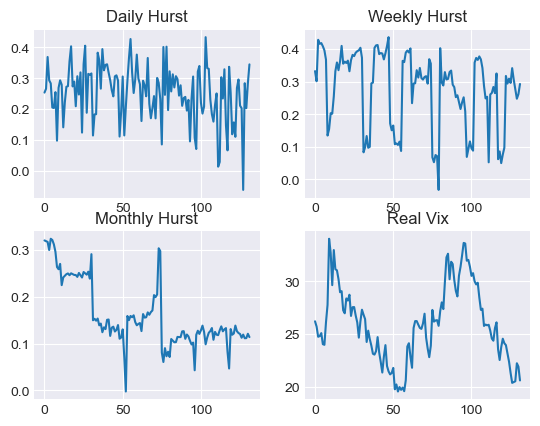

In [379]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# Prepare for the sub plots
axis[0, 0].plot(final_data['H_Daily'])
axis[0, 0].set_title('Daily Hurst')

axis[0, 1].plot(final_data['H_Weekly'])
axis[0, 1].set_title('Weekly Hurst')
  
axis[1, 0].plot(final_data['H_Monthly'])
axis[1, 0].set_title('Monthly Hurst')

axis[1, 1].plot(final_data['Real_VIX'])
axis[1, 1].set_title('Real Vix')

# Combine all the operations and display
plt.show()

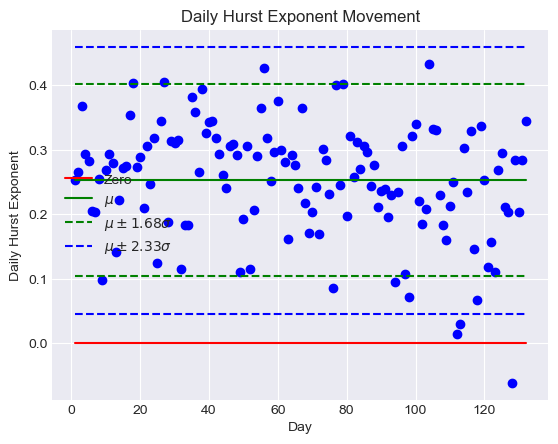

In [380]:
# Detect abnormal (negative) Hurst exponents
plot_x = np.arange(1, len(final_data)+1, 1)

plt.scatter(plot_x, final_data['H_Daily'], c='b')
plt.plot(plot_x, [0]*len(plot_x), c='r', label='Zero')
plt.plot(plot_x, [final_data['H_Daily'].mean()]*len(plot_x), c='g', label=r'$\mu$')

plt.plot(plot_x, [(final_data['H_Daily'].mean() + final_data['H_Daily'].std()*1.68)]*len(plot_x), c='g', linestyle='dashed', label=r'$\mu\pm1.68\sigma$')
plt.plot(plot_x, [(final_data['H_Daily'].mean() - final_data['H_Daily'].std()*1.68)]*len(plot_x), c='g', linestyle='dashed')

plt.plot(plot_x, [(final_data['H_Daily'].mean() + final_data['H_Daily'].std()*2.33)]*len(plot_x), c='b', linestyle='dashed', label=r'$\mu\pm2.33\sigma$')
plt.plot(plot_x, [(final_data['H_Daily'].mean() - final_data['H_Daily'].std()*2.33)]*len(plot_x), c='b', linestyle='dashed')
plt.title('Daily Hurst Exponent Movement')
plt.xlabel('Day')
plt.ylabel('Daily Hurst Exponent')
plt.legend()
plt.show()

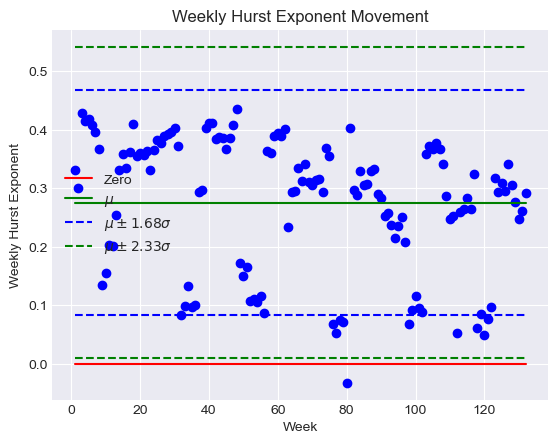

In [381]:
plt.scatter(plot_x, final_data['H_Weekly'], c='b')
plt.plot(plot_x, [0]*len(final_data), c='r', label='Zero')
plt.plot(plot_x, [final_data['H_Weekly'].mean()]*len(final_data), c='g', label=r'$\mu$')

plt.plot(plot_x, [(final_data['H_Weekly'].mean() + final_data['H_Weekly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed', label=r'$\mu\pm1.68\sigma$')
plt.plot(plot_x, [(final_data['H_Weekly'].mean() - final_data['H_Weekly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed')


plt.plot(plot_x, [(final_data['H_Weekly'].mean() + final_data['H_Weekly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed', label=r'$\mu\pm2.33\sigma$')
plt.plot(plot_x, [(final_data['H_Weekly'].mean() - final_data['H_Weekly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed')
plt.title('Weekly Hurst Exponent Movement')
plt.xlabel('Week')
plt.ylabel('Weekly Hurst Exponent')
plt.legend()

plt.show()

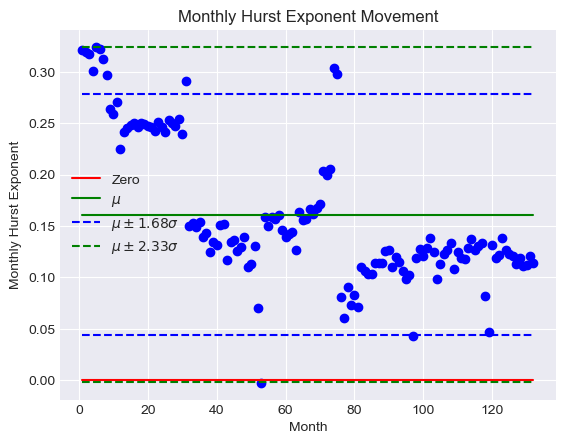

In [382]:
plt.scatter(plot_x, final_data['H_Monthly'], c='b')
plt.plot(plot_x, [0]*len(final_data), c='r', label='Zero')
plt.plot(plot_x, [final_data['H_Monthly'].mean()]*len(final_data), c='g', label=r'$\mu$')

plt.plot(plot_x, [(final_data['H_Monthly'].mean() + final_data['H_Monthly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed', label=r'$\mu\pm1.68\sigma$')
plt.plot(plot_x, [(final_data['H_Monthly'].mean() - final_data['H_Monthly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed')


plt.plot(plot_x, [(final_data['H_Monthly'].mean() + final_data['H_Monthly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed', label=r'$\mu\pm2.33\sigma$')
plt.plot(plot_x, [(final_data['H_Monthly'].mean() - final_data['H_Monthly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed')
plt.title('Monthly Hurst Exponent Movement')
plt.xlabel('Month')
plt.ylabel('Monthly Hurst Exponent')
plt.legend()

plt.show()

Locate the negative Hurst exponent(s) and fix it (or not)

In [383]:
negative_final = final_data.copy()
negative_index_Daily = negative_final[negative_final['H_Daily'] < 0].index
negative_index_Daily

Index([127], dtype='int64')

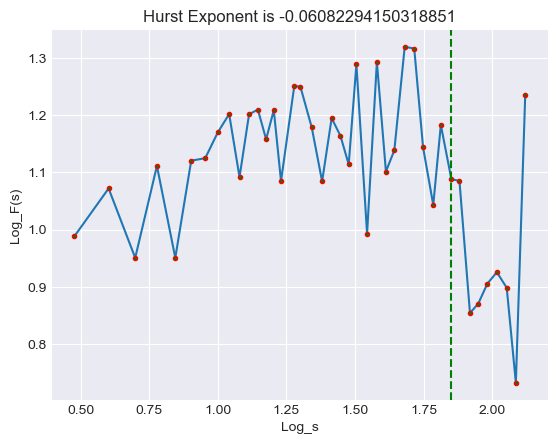

In [384]:
# Review the negative Hurst exponent process
n_sample = avg_daily
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))

# Log-log plot and calculate H
log10_lag = np.log10(scales)
log10_F = np.log10(np.array(F_summary_daily['q_2.0_127']).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.axvline(x = np.log10(scales[-9]), color = 'g', linestyle='dashed') # Draw the line to seperate uptrend and downtrend
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title(f'Hurst Exponent is {hurst_hat}')
plt.show()

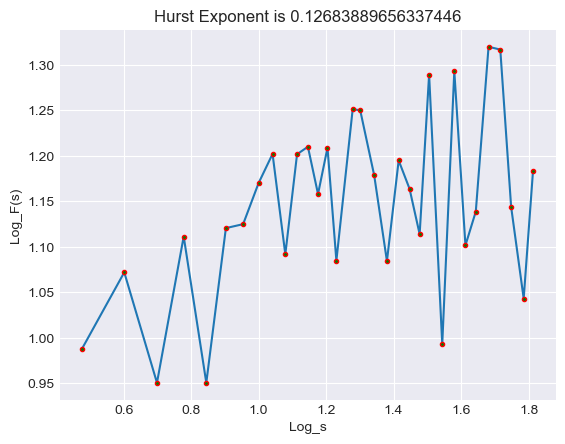

In [385]:
log10_lag = np.log10(scales)[:-9]
log10_F = np.log10(np.array(F_summary_daily['q_2.0_127'][:-9]).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title(f'Hurst Exponent is {hurst_hat}')
plt.show()

We'll continue the study on the original data and work on removing the abnormal ones later

# EDA of The Findings

## Analyze the absolute numbers

### Relationship between Hurst Exponents and VIX Index

#### OLS Regression

In [386]:
final_data = pd.read_csv('Final Data_vix_08192023.csv', index_col=0)
len(final_data)

132

In [387]:
# Add columns of returns
final_data['Return_H_Daily'] = np.log(final_data['H_Daily']).diff()
final_data['Return_H_Weekly'] = np.log(final_data['H_Weekly']).diff()
final_data['Return_H_Monthly'] = np.log(final_data['H_Monthly']).diff()
final_data['Return_VIX'] = np.log(final_data['Real_VIX']).diff()
final_data['Cum_Return_VIX'] = final_data['Return_VIX'].cumsum()

# Add a column of next day's VIX
final_data['Target_VIX'] = final_data['Real_VIX'].shift(-1)
final_data['Target_H_Daily'] = final_data['H_Daily'].shift(-1)

# Drop NAN rows
final_data.dropna(inplace=True)

# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_returns_08192023.csv')

len(final_data)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


124

In [388]:
original_ols = final_data.copy()

original_Y_ols = original_ols['Target_VIX']
original_X_ols = original_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
original_X_ols = sm.add_constant(original_X_ols)
original_model_ols = sm.OLS(original_Y_ols, original_X_ols)
original_results_ols = original_model_ols.fit()

print(original_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             Target_VIX   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.414
Date:                Mon, 21 Aug 2023   Prob (F-statistic):              0.242
Time:                        16:11:56   Log-Likelihood:                -331.96
No. Observations:                 124   AIC:                             671.9
Df Residuals:                     120   BIC:                             683.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6886      1.234     21.621      0.0

In [389]:
# Predict VIX return based on Hurst expononents
original_Y_ols_1 = original_ols['Return_VIX']
original_X_ols_1 = original_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
original_X_ols_1 = sm.add_constant(original_X_ols_1)
original_model_ols_1 = sm.OLS(original_Y_ols_1, original_X_ols_1)
original_results_ols_1 = original_model_ols_1.fit()

print(original_results_ols_1.summary())

                            OLS Regression Results                            
Dep. Variable:             Return_VIX   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.2146
Date:                Mon, 21 Aug 2023   Prob (F-statistic):              0.886
Time:                        16:12:25   Log-Likelihood:                 192.04
No. Observations:                 124   AIC:                            -376.1
Df Residuals:                     120   BIC:                            -364.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0084      0.018     -0.468      0.6

#### Predict the Movement Direction of VIX

Support Vector Machine (SVM)

In [412]:
direction_vix_svm = pd.read_csv('Final Data_vix_08192023.csv', index_col=0)
direction_vix_svm['Return_VIX'] = np.log(final_data['Real_VIX']).diff()

In [413]:
# Store all predictor variables in a variable X
X = direction_vix_svm[['H_Daily', 'H_Weekly', 'H_Monthly']]

# Definining the target variables
y = np.where(direction_vix_svm['Real_VIX'].shift(-1) > direction_vix_svm['Real_VIX'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)

# Preedict code
direction_vix_svm['Predicted_Signal'] = cls.predict(X)

# Show the score
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The out-of-sample score is 0.6666666666666666
The cross validation scores are [0.59090909 0.59090909 0.59090909 0.54545455 0.54545455 0.54545455]
0.57 accuracy with a standard deviation of 0.02


Scale the datasets, then perform the SVM again

In [414]:
scaling_minmax = MinMaxScaler()
scaled_direction_vix_svm = pd.DataFrame()
scaled_direction_vix_svm['H_Daily'] = final_data['H_Daily']
scaled_direction_vix_svm['H_Weekly'] = final_data['H_Weekly']
scaled_direction_vix_svm['H_Monthly'] = final_data['H_Monthly']
scaled_direction_vix_svm['Real_VIX'] = final_data['Real_VIX']
scaled_direction_vix_svm = scaling_minmax.fit_transform(scaled_direction_vix_svm)
scaled_direction_vix_svm = pd.DataFrame(scaled_direction_vix_svm, 
                                        columns=['H_Daily', 'H_Weekly', 
                                                 'H_Monthly', 'Real_VIX'])
scaled_direction_vix_svm

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.637207,0.777716,0.989170,0.459627
1,0.662466,0.711334,0.984294,0.425121
2,0.870227,0.982847,0.979564,0.358178
3,0.717608,0.956291,0.926529,0.363009
4,0.697378,0.961424,1.000000,0.382333
5,0.539558,0.940549,0.992171,0.309869
6,0.536112,0.913591,0.963462,0.305728
7,0.640103,0.852758,0.914818,0.452726
8,0.322433,0.356008,0.815016,0.567288
9,0.668365,0.398763,0.800585,1.000000


In [415]:
# Store all predictor variables in a variable X
X = scaled_direction_vix_svm[['H_Daily', 'H_Weekly', 'H_Monthly']]

# Definining the target variables
y = np.where(scaled_direction_vix_svm['Real_VIX'].shift(-1) > scaled_direction_vix_svm['Real_VIX'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)

# Show the score
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The out-of-sample score is 0.6666666666666666
The cross validation scores are [0.59090909 0.59090909 0.59090909 0.54545455 0.54545455 0.54545455]
0.57 accuracy with a standard deviation of 0.02


The scaling above shows that it didn't improve the prediction ability

Visualize the SVM Prediction

In [416]:
direction_vix_svm

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX,Predicted_Signal
0,0.253341,0.332134,0.320647,26.19,NaN,0
1,0.265794,0.301009,0.319054,25.69,-0.019276,0
2,0.368227,0.428313,0.317509,24.72,-0.038489,0
3,0.292981,0.415862,0.300188,24.79,0.002828,0
4,0.283007,0.418269,0.324184,25.07,0.011232,0
5,0.205196,0.408481,0.321627,24.02,-0.042785,0
6,0.203497,0.395841,0.312250,23.96,-0.002501,0
7,0.254768,0.367319,0.296363,26.09,0.085166,0
8,0.098147,0.134408,0.263767,27.75,0.061684,0
9,0.268702,0.154454,0.259053,34.02,0.203713,0


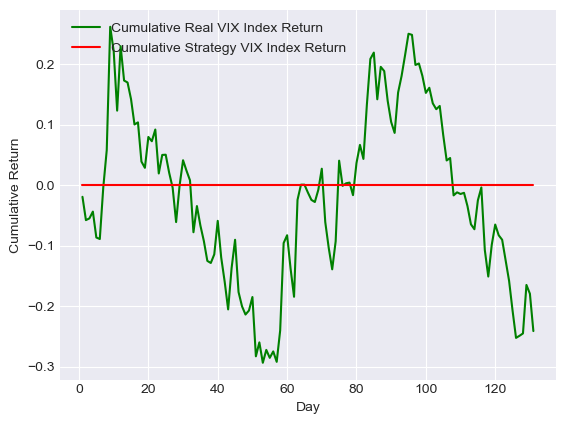

In [417]:
# Calculate strategy returns
direction_vix_svm['Strategy_Return'] = direction_vix_svm['Return_VIX'] * direction_vix_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
direction_vix_svm['Cum_VIX_Ret'] = direction_vix_svm['Return_VIX'].cumsum()
direction_vix_svm['Cum_Strategy'] = direction_vix_svm['Strategy_Return'].cumsum()

# Plot Strategy Returns vs Original Returns
plt.plot(direction_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(direction_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

### Predict the Hurst Exponent

#### OLS Regression

In [425]:
final_data = pd.read_csv('final_data_May2022-Nov2022_returns_08192023.csv')

# Create a new dataframe to analyze relationships between Hurst exponents at different time spots
H_est = pd.DataFrame()
H_est['H_Daily'] = final_data['H_Daily'].copy()
H_est['H_Weekly'] = final_data['H_Weekly'].copy()
H_est['H_Monthly'] = final_data['H_Monthly'].copy()
H_est['Target_H_Daily'] = final_data['Target_H_Daily']
H_est.dropna(inplace=True)

H_est

,H_Daily,H_Weekly,H_Monthly,Target_H_Daily
0,0.265794,0.301009,0.319054,0.368227
1,0.368227,0.428313,0.317509,0.292981
2,0.292981,0.415862,0.300188,0.283007
3,0.283007,0.418269,0.324184,0.205196
4,0.205196,0.408481,0.321627,0.203497
5,0.203497,0.395841,0.312250,0.254768
6,0.254768,0.367319,0.296363,0.098147
7,0.098147,0.134408,0.263767,0.268702
8,0.268702,0.154454,0.259053,0.292869
9,0.292869,0.203015,0.270522,0.278751


In [426]:
H_est_ols = H_est.copy()

H_est_Y_ols = H_est_ols['Target_H_Daily']
H_est_X_ols = H_est_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
H_est_X_ols = sm.add_constant(H_est_X_ols)
H_est_model_ols = sm.OLS(H_est_Y_ols, H_est_X_ols)
H_est_results_ols = H_est_model_ols.fit()

print(H_est_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         Target_H_Daily   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.787
Date:                Mon, 21 Aug 2023   Prob (F-statistic):              0.153
Time:                        17:09:56   Log-Likelihood:                 125.17
No. Observations:                 124   AIC:                            -242.3
Df Residuals:                     120   BIC:                            -231.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.031      6.154      0.0

## Analyze the percentage change

In [505]:
final_data = pd.read_csv('final_data_May2022-Nov2022_returns_08192023.csv')

final_data_diff = pd.DataFrame()

final_data_diff['delta_H_D'] = final_data['Return_H_Daily']
final_data_diff['delta_H_W'] = final_data['Return_H_Weekly']
final_data_diff['delta_H_M'] = final_data['Return_H_Monthly']
final_data_diff['delta_Real_V'] = final_data['Return_VIX']

final_data_diff

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V
0,0.047987,-0.098397,-0.004979,-0.019276
1,0.325978,0.352714,-0.004854,-0.038489
2,-0.228593,-0.029501,-0.056099,0.002828
3,-0.034635,0.005770,0.076903,0.011232
4,-0.321504,-0.023679,-0.007919,-0.042785
5,-0.008315,-0.031433,-0.029587,-0.002501
6,0.224703,-0.074783,-0.052221,0.085166
7,-0.953892,-1.005352,-0.116519,0.061684
8,1.007141,0.139019,-0.018031,0.203713
9,0.086122,0.273381,0.043319,-0.039879


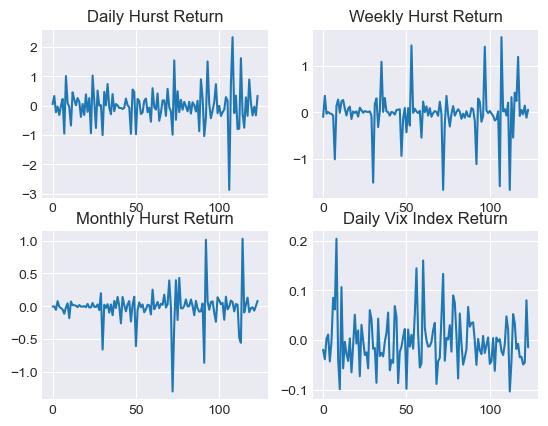

In [506]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(final_data_diff['delta_H_D'])
axis[0, 0].set_title('Daily Hurst Return')
  
# For Cosine Function
axis[0, 1].plot(final_data_diff['delta_H_W'])
axis[0, 1].set_title('Weekly Hurst Return')
  
# For Tangent Function
axis[1, 0].plot(final_data_diff['delta_H_M'])
axis[1, 0].set_title('Monthly Hurst Return')
  
# For Tanh Function
axis[1, 1].plot(final_data_diff['delta_Real_V'])
axis[1, 1].set_title('Daily Vix Index Return')
  
# Combine all the operations and display
plt.show()

In [507]:
pct_vix_svm = final_data_diff.copy()

# Store all predictor variables in a variable X
X = pct_vix_svm[['delta_H_D', 'delta_H_W', 'delta_H_M']]

# Definining the target variables
y = np.where(pct_vix_svm['delta_Real_V'].shift(-1) > pct_vix_svm['delta_Real_V'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(f'The in-sample score is {cls.score(X_train, y_train)}')
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The in-sample score is 0.5959595959595959
The out-of-sample score is 0.72
The cross validation scores are [0.57142857 0.57142857 0.52380952 0.47619048 0.45       0.75      ]
0.56 accuracy with a standard deviation of 0.10


In [508]:
# Predict the signals
pct_vix_svm['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
pct_vix_svm['VIX_Return'] = pct_vix_svm['delta_Real_V']

# Calculate strategy returns
pct_vix_svm['Strategy_Return'] = pct_vix_svm['VIX_Return'] * pct_vix_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
pct_vix_svm['Cum_VIX_Ret'] = pct_vix_svm['VIX_Return'].cumsum()
pct_vix_svm['Cum_Strategy'] = pct_vix_svm['Strategy_Return'].cumsum()

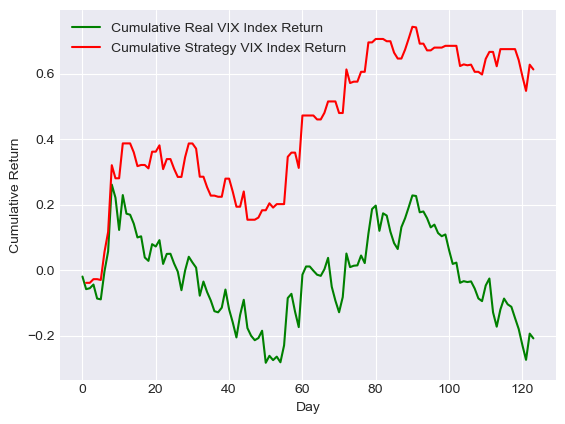

In [509]:
# Plot Strategy Returns vs Original Returns
plt.plot(pct_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(pct_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

Filter out the extreme values ($2.33\sigma$ away from $\mu$)

In [510]:
# Remove those over pct change data points three standard deviation away from mean
# A general function to remove the outliers by ZSCORE method
def remove_outliers(df, col, threshold=2.33):
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    return filtered_df

filtered_final_diff = remove_outliers(final_data_diff[1:], ['delta_H_D', 'delta_H_W', 'delta_H_M', 'delta_Real_V'])
filtered_final_diff

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V
1,0.325978,0.352714,-0.004854,-0.038489
2,-0.228593,-0.029501,-0.056099,0.002828
3,-0.034635,0.005770,0.076903,0.011232
4,-0.321504,-0.023679,-0.007919,-0.042785
5,-0.008315,-0.031433,-0.029587,-0.002501
6,0.224703,-0.074783,-0.052221,0.085166
7,-0.953892,-1.005352,-0.116519,0.061684
9,0.086122,0.273381,0.043319,-0.039879
10,-0.049408,-0.008432,-0.184023,-0.098619
11,-0.680185,0.236163,0.070752,0.106541


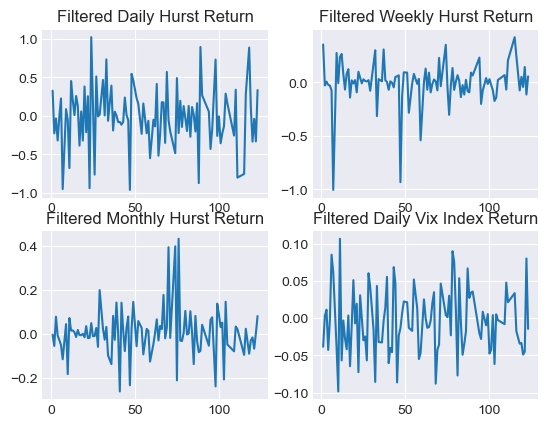

In [511]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(filtered_final_diff['delta_H_D'])
axis[0, 0].set_title('Filtered Daily Hurst Return')
  
# For Cosine Function
axis[0, 1].plot(filtered_final_diff['delta_H_W'])
axis[0, 1].set_title('Filtered Weekly Hurst Return')
  
# For Tangent Function
axis[1, 0].plot(filtered_final_diff['delta_H_M'])
axis[1, 0].set_title('Filtered Monthly Hurst Return')
  
# For Tanh Function
axis[1, 1].plot(filtered_final_diff['delta_Real_V'])
axis[1, 1].set_title('Filtered Daily Vix Index Return')
  
# Combine all the operations and display
plt.show()

### Predict VIX Movement

Filtered data OLS regression

In [512]:
filtered_ols = filtered_final_diff.copy()

filtered_Y_ols = filtered_ols['delta_Real_V']
filtered_X_ols = filtered_ols[['delta_H_D', 'delta_H_W', 'delta_H_M']]
filtered_X_ols = sm.add_constant(filtered_X_ols)
filtered_model_ols = sm.OLS(filtered_Y_ols, filtered_X_ols)
filtered_results_ols = filtered_model_ols.fit()

print(filtered_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_Real_V   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.163
Date:                Mon, 21 Aug 2023   Prob (F-statistic):              0.328
Time:                        18:54:09   Log-Likelihood:                 179.90
No. Observations:                 103   AIC:                            -351.8
Df Residuals:                      99   BIC:                            -341.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.004     -1.101      0.2

SVM

In [513]:
pct_vix_svm = filtered_final_diff.copy()

# Store all predictor variables in a variable X
X = pct_vix_svm[['delta_H_D', 'delta_H_W', 'delta_H_M']]

# Definining the target variables
y = np.where(pct_vix_svm['delta_Real_V'].shift(-1) > pct_vix_svm['delta_Real_V'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(f'The in-sample score is {cls.score(X_train, y_train)}')
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The in-sample score is 0.5487804878048781
The out-of-sample score is 0.5714285714285714
The cross validation scores are [0.44444444 0.47058824 0.29411765 0.70588235 0.47058824 0.41176471]
0.47 accuracy with a standard deviation of 0.12


Visualize

In [515]:
# Predict the signals
pct_vix_svm['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
pct_vix_svm['VIX_Return'] = pct_vix_svm['delta_Real_V']

# Calculate strategy returns
pct_vix_svm['Strategy_Return'] = pct_vix_svm['VIX_Return'] * pct_vix_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
pct_vix_svm['Cum_VIX_Ret'] = pct_vix_svm['VIX_Return'].cumsum()
pct_vix_svm['Cum_Strategy'] = pct_vix_svm['Strategy_Return'].cumsum()

In [516]:
pct_vix_svm

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V,Predicted_Signal,VIX_Return,Strategy_Return,Cum_VIX_Ret,Cum_Strategy
1,0.325978,0.352714,-0.004854,-0.038489,1,-0.038489,NaN,-0.038489,NaN
2,-0.228593,-0.029501,-0.056099,0.002828,1,0.002828,0.002828,-0.035661,0.002828
3,-0.034635,0.005770,0.076903,0.011232,1,0.011232,0.011232,-0.024430,0.014059
4,-0.321504,-0.023679,-0.007919,-0.042785,1,-0.042785,-0.042785,-0.067215,-0.028726
5,-0.008315,-0.031433,-0.029587,-0.002501,1,-0.002501,-0.002501,-0.069716,-0.031227
6,0.224703,-0.074783,-0.052221,0.085166,1,0.085166,0.085166,0.015450,0.053939
7,-0.953892,-1.005352,-0.116519,0.061684,1,0.061684,0.061684,0.077134,0.115623
9,0.086122,0.273381,0.043319,-0.039879,1,-0.039879,-0.039879,0.037255,0.075744
10,-0.049408,-0.008432,-0.184023,-0.098619,1,-0.098619,-0.098619,-0.061365,-0.022876
11,-0.680185,0.236163,0.070752,0.106541,1,0.106541,0.106541,0.045177,0.083666


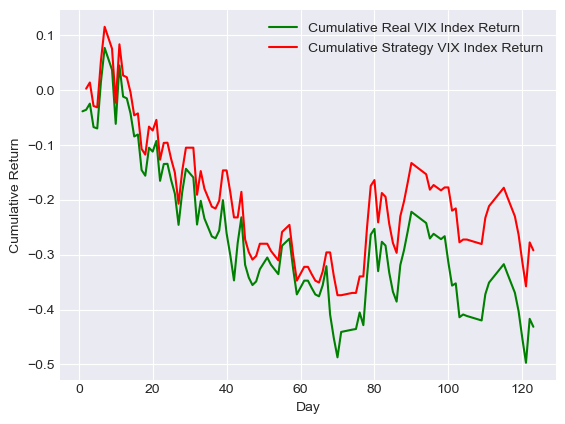

In [517]:
# Plot Strategy Returns vs Original Returns
plt.plot(pct_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(pct_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

Adjust the moving average

In [518]:
final_data = pd.read_csv('Final Data_vix_08192023.csv', index_col=0)
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.253341,0.332134,0.320647,26.19
1,0.265794,0.301009,0.319054,25.69
2,0.368227,0.428313,0.317509,24.72
3,0.292981,0.415862,0.300188,24.79
4,0.283007,0.418269,0.324184,25.07
5,0.205196,0.408481,0.321627,24.02
6,0.203497,0.395841,0.312250,23.96
7,0.254768,0.367319,0.296363,26.09
8,0.098147,0.134408,0.263767,27.75
9,0.268702,0.154454,0.259053,34.02


In [519]:
# Create a new dataframe to analyze relationships between Hurst exponents at different time spots

H_est = pd.DataFrame()
H_est['T_H_Daily'] = final_data['H_Daily'].copy()
H_est['T_H_Weekly'] = final_data['H_Weekly'].copy()
H_est['T_H_Monthly'] = final_data['H_Monthly'].copy()
H_est['T_Real_VIX'] = final_data['Real_VIX'].copy()
H_est['T-1_H_Daily'] = H_est['T_H_Daily'].shift(1)
H_est['T-5_H_Weekly'] = H_est['T_H_Weekly'].shift(5)
H_est['T-22_H_Monthly'] = H_est['T_H_Monthly'].shift(22)
H_est.dropna(inplace=True)

H_est

,T_H_Daily,T_H_Weekly,T_H_Monthly,T_Real_VIX,T-1_H_Daily,T-5_H_Weekly,T-22_H_Monthly
22,0.247113,0.331734,0.251102,28.71,0.306111,0.409569,0.320647
23,0.318511,0.365878,0.246112,26.70,0.247113,0.354942,0.319054
24,0.124169,0.382015,0.241323,27.53,0.318511,0.361344,0.317509
25,0.344925,0.378150,0.253122,27.54,0.124169,0.357090,0.300188
26,0.404647,0.388752,0.250167,26.73,0.344925,0.364334,0.324184
27,0.188215,0.393241,0.247390,26.08,0.404647,0.331734,0.321627
28,0.313777,0.396011,0.253825,24.64,0.188215,0.365878,0.312250
29,0.310976,0.403853,0.238953,26.17,0.313777,0.382015,0.296363
30,0.315187,0.373026,0.291262,27.29,0.310976,0.378150,0.263767
31,0.114803,0.082927,0.149926,26.82,0.315187,0.388752,0.259053


In [520]:
H_est_ols = H_est.copy()
# H_est_ols
H_est_Y_ols = H_est_ols['T_Real_VIX']
H_est_X_ols = H_est_ols[['T-1_H_Daily', 'T-5_H_Weekly', 'T-22_H_Monthly']]
H_est_X_ols = sm.add_constant(H_est_X_ols)
H_est_model_ols = sm.OLS(H_est_Y_ols, H_est_X_ols)
H_est_results_ols = H_est_model_ols.fit()

print(H_est_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             T_Real_VIX   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                   0.07974
Date:                Mon, 21 Aug 2023   Prob (F-statistic):              0.971
Time:                        18:54:10   Log-Likelihood:                -296.23
No. Observations:                 110   AIC:                             600.5
Df Residuals:                     106   BIC:                             611.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             26.1921      1.440     18.

In [521]:
H_est_svm = H_est.copy()

# Store all predictor variables in a variable X
X = H_est_svm[['T-1_H_Daily', 'T-5_H_Weekly', 'T-22_H_Monthly']]

# Definining the target variables
y = np.where(H_est_svm['T_Real_VIX'].shift(-1) > H_est_svm['T_Real_VIX'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

cls = SVC(kernel='linear', C=1).fit(X_train, y_train)

In [522]:
print(f'in-sample score is {cls.score(X_train, y_train)}')
print(f'out-of-sample score is {cls.score(X_test, y_test)}')

in-sample score is 0.5340909090909091
out-of-sample score is 0.6818181818181818


Cross validation

In [523]:
scores = cross_val_score(cls, X, y, cv=10)
print(f'cross validation scores are {scores}')

cross validation scores are [0.63636364 0.63636364 0.54545455 0.54545455 0.54545455 0.54545455
 0.54545455 0.54545455 0.54545455 0.54545455]


In [524]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.56 accuracy with a standard deviation of 0.04


Visualization

In [525]:
#Preedict code
H_est_svm['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
H_est_svm['VIX_Return'] = H_est_svm.T_Real_VIX.pct_change()

# Calculate strategy returns
H_est_svm['Strategy_Return'] = H_est_svm['VIX_Return'] * H_est_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
H_est_svm['Cum_VIX_Ret'] = H_est_svm['VIX_Return'].cumsum()
H_est_svm['Cum_Strategy'] = H_est_svm['Strategy_Return'].cumsum()

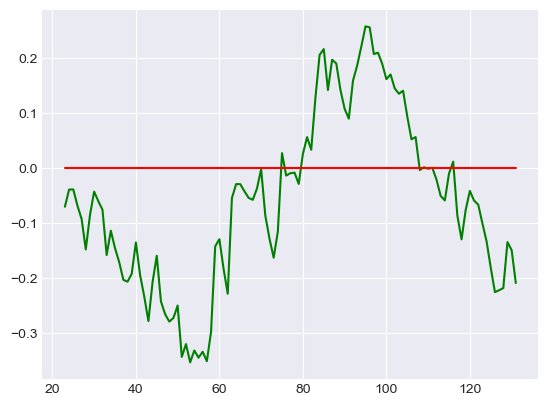

In [526]:
# Plot Strategy Returns vs Original Returns
plt.plot(H_est_svm['Cum_VIX_Ret'], color='green')
plt.plot(H_est_svm['Cum_Strategy'], color='red')

The above analyses show no apparent relationships between Hurst exponents and VIX index. Let's see if we can trade VIX based on Hurst exponent signals.

### Compared with History Volatility

In [550]:
df_temp = pd.read_csv('Final Data_vix_08192023.csv', index_col=0)
hv = pd.DataFrame()
hv['vix'] = df_temp['Real_VIX']
hv['vol_vix'] = (hv['vix'].rolling(22).std()) ** 2 * 252

hv['vol_1'] = hv['vol_vix'].shift(1)
hv['vol_5'] = hv['vol_vix'].shift(5)
hv['vol_22'] = hv['vol_vix'].shift(22)

hv['ret_vix'] = np.log(hv['vix']).diff()
hv['ret_vol_1'] = np.log(hv['vol_1']).diff()
hv['ret_vol_5'] = np.log(hv['vol_5']).diff()
hv['ret_vol_22'] = np.log(hv['vol_22']).diff()

hv.dropna(inplace=True)
hv

,vix,vol_vix,vol_1,vol_5,vol_22,ret_vix,ret_vol_1,ret_vol_5,ret_vol_22
44,22.84,869.659636,974.519182,775.174036,2197.882527,0.068399,0.101594,-0.007539,-0.019778
45,23.93,837.703909,869.659636,776.088436,2147.920582,0.046620,-0.113842,0.001179,-0.022994
46,21.95,824.920636,837.703909,841.795909,1998.341727,-0.086366,-0.037437,0.081271,-0.072183
47,21.44,808.683545,824.920636,880.376945,1846.256727,-0.023509,-0.015378,0.044813,-0.079158
48,21.15,831.936927,808.683545,974.519182,1739.902036,-0.013618,-0.019880,0.101594,-0.059331
49,21.29,854.118982,831.936927,869.659636,1561.715782,0.006598,0.028349,-0.113842,-0.108044
50,21.77,888.480709,854.118982,837.703909,1489.640727,0.022295,0.026314,-0.037437,-0.047250
51,19.74,971.427709,888.480709,824.920636,1484.641745,-0.097886,0.039442,-0.015378,-0.003361
52,20.20,876.176782,971.427709,808.683545,1497.944945,0.023036,0.089254,-0.019880,0.008921
53,19.53,820.786036,876.176782,831.936927,1174.966036,-0.033731,-0.103199,0.028349,-0.242855


In [552]:
hv_ols = hv.copy()
# H_est_ols
hv_Y_ols = hv['ret_vix']
hv_X_ols = hv_ols[['ret_vol_1', 'ret_vol_5', 'ret_vol_22']]
hv_X_ols = sm.add_constant(hv_X_ols)
hv_model_ols = sm.OLS(hv_Y_ols, hv_X_ols)
hv_results_ols = hv_model_ols.fit()

print(hv_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_vix   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.4651
Date:                Mon, 21 Aug 2023   Prob (F-statistic):              0.707
Time:                        19:30:16   Log-Likelihood:                 142.14
No. Observations:                  88   AIC:                            -276.3
Df Residuals:                      84   BIC:                            -266.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.005     -0.040      0.9

In [551]:
hv_svm = hv.copy()

# Store all predictor variables in a variable X
X = hv_svm[['ret_vol_1', 'ret_vol_5', 'ret_vol_22']]

# Definining the target variables
y = np.where(hv_svm['vix'].shift(-1) > hv_svm['vix'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(f'The in-sample score is {cls.score(X_train, y_train)}')
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The in-sample score is 0.5285714285714286
The out-of-sample score is 0.6111111111111112
The cross validation scores are [0.53333333 0.53333333 0.53333333 0.53333333 0.57142857 0.57142857]
0.55 accuracy with a standard deviation of 0.02


In [553]:
# Predict the signals
hv_svm['Predicted_Signal'] = cls.predict(X)

# Calculate strategy returns
hv_svm['Strategy_Return'] = hv_svm['ret_vix'] * hv_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
hv_svm['Cum_VIX_Ret'] = hv_svm['ret_vix'].cumsum()
hv_svm['Cum_Strategy'] = hv_svm['Strategy_Return'].cumsum()

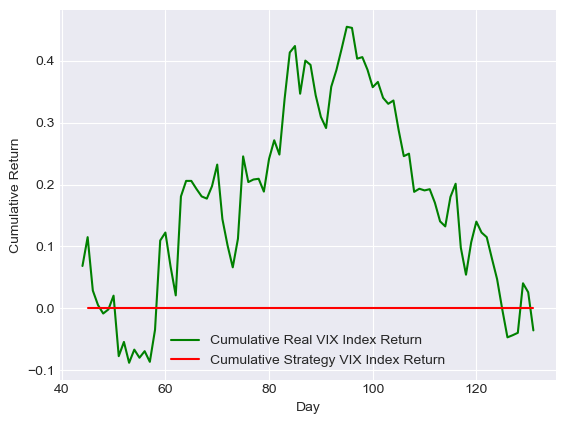

In [555]:
# Plot Strategy Returns vs Original Returns
plt.plot(hv_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(hv_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

# Future Study

The number of dataset on daily, weekly and monthly bases are not even due to (1) uncontinuous data (interval greater than one minute); (2) change of daylight saving time; (3) holidays of different countries and; (4) time zones (the date of of VIX index closing price is not always the same as GMT). Future study will (1) fill the missing data using systematic approaches, e.g., interpolation; (2) 

<AxesSubplot:xlabel='Time'>

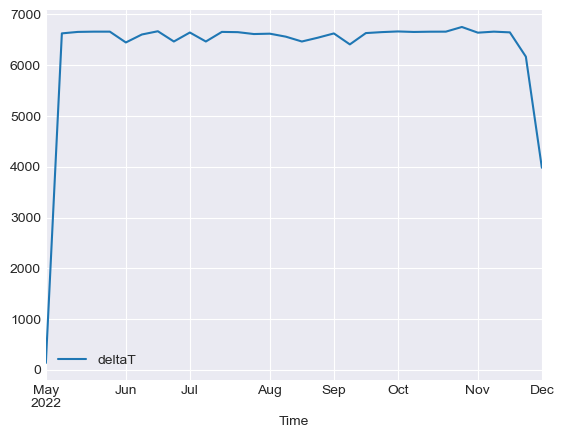

In [527]:
# Weekly data availability fluctuates
available_weekly.plot()

day_of_week
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

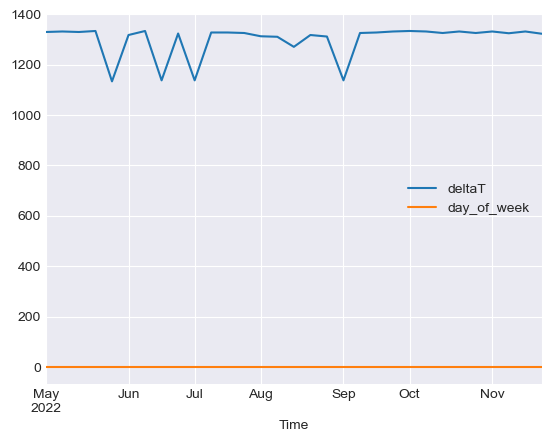

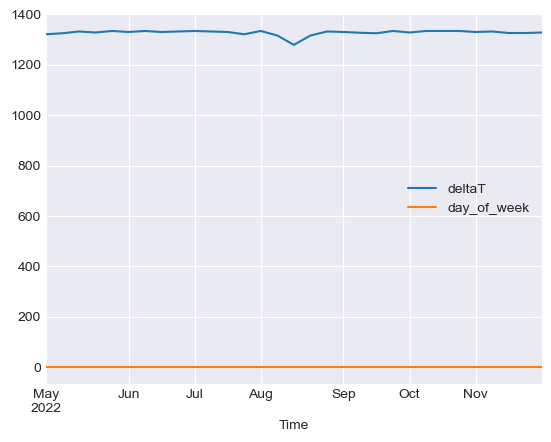

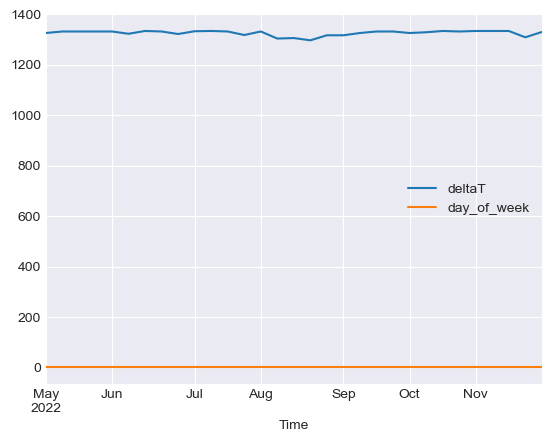

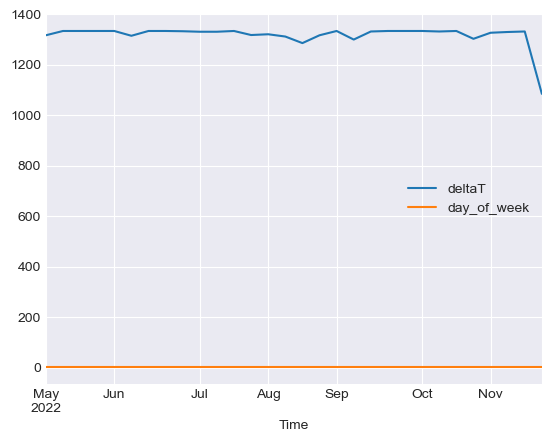

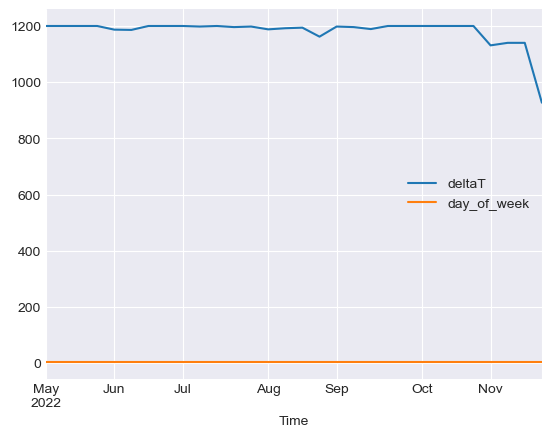

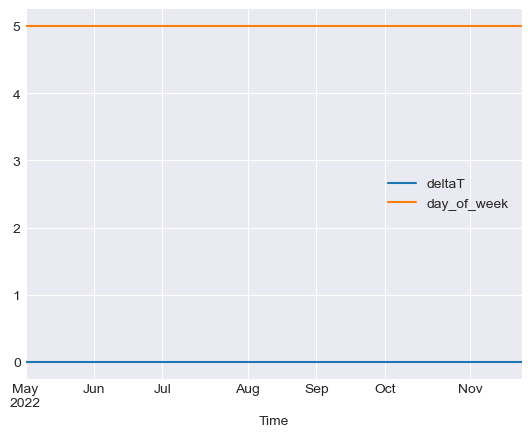

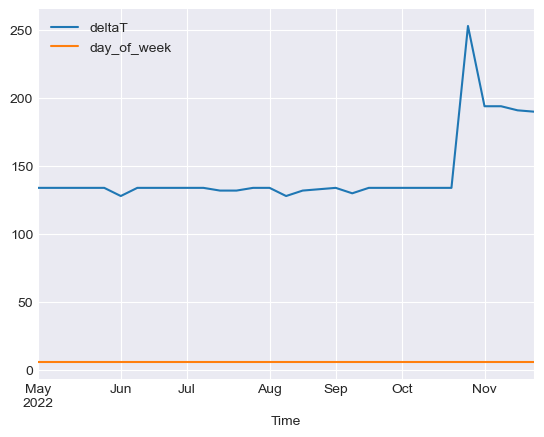

In [528]:
# Daily data ability fluctuates
available_daily.groupby(['day_of_week']).plot()

<AxesSubplot:xlabel='Time'>

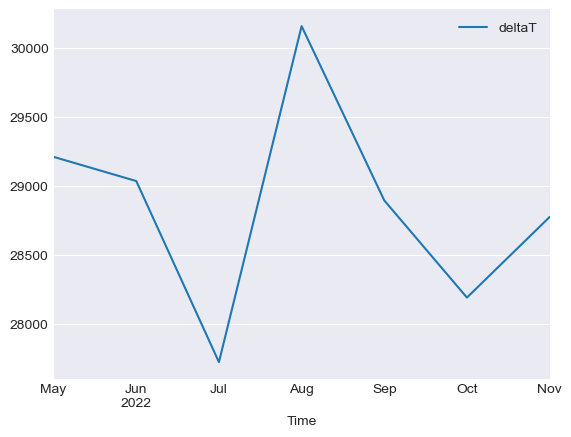

In [529]:
available_monthly.plot()